# Core - Series 1

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from matplotlib.backends.backend_pdf import PdfPages
from IPython.display import display
from analysis_util.constants import PROTOCOLS, IP_VERSIONS, CONTINENTS, CONTINENT_NAMES, CONTINENT_DISPLAY_ORDER
from analysis_util.constants import RESOLVER_NAMES, RESOLVER_ADDRESSES, RESOLVER_DISPLAY_ORDER, AS_NAMES
from analysis_util.db_util import DatabaseReader 
from analysis_util.df_manipulation import create_resolver_column, create_continent_name_column
from analysis_util.df_manipulation import create_traceroute_resolver_column, create_table_column
from analysis_util.file_util import PlotSaver
from analysis_util.plot_util import get_plot_index, plot_heatmap

# Global functions

In [2]:
db = DatabaseReader("data/ripe_results_txt.db")
saver = PlotSaver("plots/rq2/")
saver.current_path = "edns0_options/"

In [3]:
top_ases = db.get_top_ases()

# EDNS Options

In [4]:
def select_and_prepare_edns_data(db_reader):
    v4_data = db_reader.get_edns_option_data(4)
    v6_data = db_reader.get_edns_option_data(6)
    data = [("IPv4", v4_data),
            ("IPv6", v6_data)]
    edns_option_data = []
    for (key, df) in data:
        df['resolver'] = df.apply(create_resolver_column, axis=1)
        edns_option_data.append((key,df))
    return edns_option_data
    
    

In [5]:
backend_resolvers = pd.read_csv("tmp_csv_files/backend_resolver_locations.csv")
backend_resolvers["continent_code"] = backend_resolvers["continent_code"].fillna("NA")

def get_edns_data_with_backend(ends_option_data, db_reader):
    asns = pd.read_sql("SELECT number, name as as_name FROM autonomous_systems", db_reader.conn)
    
    edns_option_data_with_backend = []
    for key, df in ends_option_data:
        df = df.merge(backend_resolvers, how="left", on="backend_resolver",suffixes=('_frontend', '_backend'))
        df = df.merge(asns, how="left", left_on="asn", right_on="number",suffixes=('_frontend', '_backend'))
        edns_option_data_with_backend.append((key, df))
    return edns_option_data_with_backend

In [6]:
edns_option_data = select_and_prepare_edns_data(db)

In [7]:
edns_option_data_with_backend = get_edns_data_with_backend(edns_option_data, db)

## Used options per resolver

In [8]:
def get_options_per_resolver(ends_option_data, saver):
    for key, df in ends_option_data:
        #df = df[df["resolver"] != "Comodo"]
        df = df[df["resolver"] != "Probe Resolver"]
        options = df["name"].unique()
        options = ["NO OPTION" if option is None else option for option in options]

        groups = df.groupby("resolver")
        new_df = pd.DataFrame(columns=options)
        print(key)
        
        for resolver, group in groups:
            size_df_without_options = len(group.groupby(by=["msm_id", "prb_id", "sub_id"], as_index=False).size().index)
            item = {}

            for option in options:
                if option == "NO OPTION":
                    count_option = len(group[group["name"].isnull()].index)
                else:
                    count_option = len(group[group["name"] == option].index)
                item[option] = count_option/size_df_without_options
            row = pd.Series(item,name=resolver)
            new_df = new_df.append(row)
        size_df_without_options = len(df.groupby(by=["msm_id", "prb_id", "sub_id"], as_index=False).size().index)
        item = {}   
        for option in options:
            if option == "NO OPTION":
                count_option = len(df[df["name"].isnull()].index)
            else:
                count_option = len(df[df["name"] == option].index)
            item[option] = count_option/size_df_without_options
        row = pd.Series(item,name="All")
        new_df = new_df.append(row)
        
        display(new_df)
        print(new_df.to_latex(float_format='{:,.2%}'.format))
        saver.save_table(new_df, f"ends_options_per_resolver_{key}.csv")

In [9]:
get_options_per_resolver(edns_option_data, saver)

IPv4


,EDNS,COOKIE,SUBNET,NO OPTION
CleanBrowsing,0.999347,0.002211,0.001026,0.000653
Cloudflare,0.999377,0.003160,0.000987,0.000623
Comodo,0.980980,0.003298,0.001072,0.019020
Google,0.999349,0.003109,0.142335,0.000651
Neustar,0.999325,0.002291,0.000965,0.000675
OpenDNS,0.999372,0.002183,0.001049,0.000628
OpenNIC,0.999347,0.002193,0.001120,0.000653
Quad9,0.999317,0.002447,0.001286,0.000683
UncensoredDNS,0.998380,0.946190,0.002372,0.001620
Yandex,0.999342,0.002187,0.001069,0.000658


\begin{tabular}{lrrrr}
\toprule
{} &   EDNS &  COOKIE &  SUBNET &  NO OPTION \\
\midrule
CleanBrowsing & 99.93\% &   0.22\% &   0.10\% &      0.07\% \\
Cloudflare    & 99.94\% &   0.32\% &   0.10\% &      0.06\% \\
Comodo        & 98.10\% &   0.33\% &   0.11\% &      1.90\% \\
Google        & 99.93\% &   0.31\% &  14.23\% &      0.07\% \\
Neustar       & 99.93\% &   0.23\% &   0.10\% &      0.07\% \\
OpenDNS       & 99.94\% &   0.22\% &   0.10\% &      0.06\% \\
OpenNIC       & 99.93\% &   0.22\% &   0.11\% &      0.07\% \\
Quad9         & 99.93\% &   0.24\% &   0.13\% &      0.07\% \\
UncensoredDNS & 99.84\% &  94.62\% &   0.24\% &      0.16\% \\
Yandex        & 99.93\% &   0.22\% &   0.11\% &      0.07\% \\
All           & 99.74\% &   4.35\% &   1.64\% &      0.26\% \\
\bottomrule
\end{tabular}

IPv6


,EDNS,COOKIE,SUBNET,NO OPTION
CleanBrowsing,0.999079,0.000542,0.000379,0.000921
Cloudflare,0.999992,0.000534,0.000471,0.000008
Google,1.000000,0.001617,0.125344,0.000000
Neustar,0.999335,0.000540,0.000352,0.000665
OpenDNS,1.000000,0.000538,0.000413,0.000000
OpenNIC,1.000000,0.000543,0.000481,0.000000
Quad9,0.999992,0.000565,0.000344,0.000008
UncensoredDNS,0.999989,0.990613,0.000627,0.000011
Yandex,1.000000,0.000540,0.000407,0.000000
All,0.999813,0.079148,0.014871,0.000187


\begin{tabular}{lrrrr}
\toprule
{} &    EDNS &  COOKIE &  SUBNET &  NO OPTION \\
\midrule
CleanBrowsing &  99.91\% &   0.05\% &   0.04\% &      0.09\% \\
Cloudflare    & 100.00\% &   0.05\% &   0.05\% &      0.00\% \\
Google        & 100.00\% &   0.16\% &  12.53\% &      0.00\% \\
Neustar       &  99.93\% &   0.05\% &   0.04\% &      0.07\% \\
OpenDNS       & 100.00\% &   0.05\% &   0.04\% &      0.00\% \\
OpenNIC       & 100.00\% &   0.05\% &   0.05\% &      0.00\% \\
Quad9         & 100.00\% &   0.06\% &   0.03\% &      0.00\% \\
UncensoredDNS & 100.00\% &  99.06\% &   0.06\% &      0.00\% \\
Yandex        & 100.00\% &   0.05\% &   0.04\% &      0.00\% \\
All           &  99.98\% &   7.91\% &   1.49\% &      0.02\% \\
\bottomrule
\end{tabular}



# Options per resolver and continent

In [50]:
def get_options_per_resolver_and_continent(edns_option_data, saver):
    for key, df in edns_option_data:
        #display(df_pubres)
        options = df["name"].unique()    
        groups = df.groupby("resolver")

        for option in options:
            new_df = pd.DataFrame(columns=["continent_code", "percentage", "resolver"])
            print(option)
            for resolver, group in groups:
                continent_counts = group.groupby(by=["msm_id", "prb_id", "sub_id", "continent_code"], as_index=False).size().groupby(by=["continent_code"], as_index=False).size()
                if option is None:
                    option_counts = group[group["name"].isnull()].groupby(["continent_code"], as_index=False).size()
                else:
                    option_counts = group[group["name"] == option].groupby(["continent_code"], as_index=False).size()
                merged = continent_counts.merge(option_counts, how="left", on=["continent_code"]).fillna(0)
                merged["percentage"] = merged["size_y"]/merged["size_x"]
                merged["resolver"] = resolver
                merged = merged[["continent_code", "percentage", "resolver"]]
                new_df = new_df.append(merged)
            ct = pd.crosstab(new_df["resolver"], new_df["continent_code"], values=new_df["percentage"], aggfunc="median")
            saver.save_table(ct, f"{option}_per_resolver_and_continent_{key}.csv")
            display(ct)


In [51]:
get_options_per_resolver_and_continent(edns_option_data, saver)

EDNS


continent_code,AF,AS,EU,NA,OC,SA
resolver,,,,,,
CleanBrowsing,1.000000,0.999552,0.999151,0.999876,0.999781,1.000000
Cloudflare,1.000000,1.000000,0.999158,0.999927,0.999655,0.999747
Comodo,0.991044,0.958453,0.992767,0.969654,0.820356,0.975177
Google,1.000000,1.000000,0.999103,0.999946,0.999774,1.000000
Neustar,1.000000,0.999930,0.999068,0.999944,1.000000,1.000000
OpenDNS,1.000000,0.999873,0.999125,0.999982,1.000000,1.000000
OpenNIC,1.000000,0.999936,0.999101,0.999929,1.000000,1.000000
Probe Resolver,0.996139,0.962867,0.988245,0.989416,0.999338,0.999097
Quad9,1.000000,0.999920,0.999077,0.999959,1.000000,1.000000


COOKIE


continent_code,AF,AS,EU,NA,OC,SA
resolver,,,,,,
CleanBrowsing,0.000000,0.000000,0.002339,0.002489,0.000000,0.007496
Cloudflare,0.000000,0.000000,0.003659,0.002505,0.000000,0.008346
Comodo,0.000000,0.000000,0.003898,0.002487,0.000000,0.006332
Google,0.000000,0.000000,0.003617,0.002465,0.000000,0.007576
Neustar,0.000000,0.000000,0.002433,0.002589,0.000000,0.006823
OpenDNS,0.000000,0.000000,0.002311,0.002485,0.000000,0.007083
OpenNIC,0.000000,0.000000,0.002313,0.002496,0.000000,0.007234
Probe Resolver,0.075611,0.096373,0.096916,0.077059,0.009269,0.180957
Quad9,0.000000,0.001920,0.002427,0.002834,0.000000,0.007338


SUBNET


continent_code,AF,AS,EU,NA,OC,SA
resolver,,,,,,
CleanBrowsing,0.000000,0.007874,0.000300,0.001191,0.001097,0.012244
Cloudflare,0.000000,0.007031,0.000306,0.001170,0.001264,0.011634
Comodo,0.000000,0.009959,0.000342,0.000919,0.001669,0.010892
Google,0.116108,0.315001,0.100178,0.226742,0.166459,0.517929
Neustar,0.000000,0.007992,0.000267,0.000987,0.001404,0.012555
OpenDNS,0.000000,0.008020,0.000412,0.000990,0.000668,0.010625
OpenNIC,0.000000,0.008299,0.000417,0.001177,0.001364,0.010975
Probe Resolver,0.018662,0.109280,0.020822,0.049767,0.044756,0.075135
Quad9,0.000000,0.015204,0.000316,0.001117,0.001545,0.010220


None


continent_code,AF,AS,EU,NA,OC,SA
resolver,,,,,,
CleanBrowsing,0.000000,0.000448,0.000849,0.000124,0.000219,0.000000
Cloudflare,0.000000,0.000000,0.000842,0.000073,0.000345,0.000253
Comodo,0.008956,0.041547,0.007233,0.030346,0.179644,0.024823
Google,0.000000,0.000000,0.000897,0.000054,0.000226,0.000000
Neustar,0.000000,0.000070,0.000932,0.000056,0.000000,0.000000
OpenDNS,0.000000,0.000127,0.000875,0.000018,0.000000,0.000000
OpenNIC,0.000000,0.000064,0.000899,0.000071,0.000000,0.000000
Probe Resolver,0.003861,0.037133,0.011755,0.010584,0.000662,0.000903
Quad9,0.000000,0.000080,0.000923,0.000041,0.000000,0.000000


EDNS


continent_code,AF,AS,EU,NA,OC,SA
resolver,,,,,,
CleanBrowsing,1.0,0.998974,0.998950,0.999546,0.999642,1.0
Cloudflare,1.0,1.000000,0.999990,1.000000,1.000000,1.0
Google,1.0,1.000000,1.000000,1.000000,1.000000,1.0
Neustar,1.0,1.000000,0.999112,1.000000,1.000000,1.0
OpenDNS,1.0,1.000000,1.000000,1.000000,1.000000,1.0
OpenNIC,1.0,1.000000,1.000000,1.000000,1.000000,1.0
Probe Resolver,NaN,1.000000,0.948472,1.000000,1.000000,1.0
Quad9,1.0,1.000000,1.000000,1.000000,0.999518,1.0
UncensoredDNS,1.0,1.000000,1.000000,1.000000,0.999191,1.0


COOKIE


continent_code,AF,AS,EU,NA,OC,SA
resolver,,,,,,
CleanBrowsing,0.0,0.000000,0.000000,0.003530,0.000000,0.000000
Cloudflare,0.0,0.000000,0.000000,0.003472,0.000000,0.000000
Google,0.0,0.000000,0.001436,0.003521,0.000000,0.000000
Neustar,0.0,0.000000,0.000000,0.003540,0.000000,0.000000
OpenDNS,0.0,0.000000,0.000000,0.003522,0.000000,0.000000
OpenNIC,0.0,0.000000,0.000000,0.003547,0.000000,0.000000
Probe Resolver,NaN,0.024096,0.177839,0.000000,0.000000,0.500000
Quad9,0.0,0.000000,0.000000,0.003959,0.000000,0.000000
UncensoredDNS,1.0,0.967891,0.996169,0.981377,0.889968,0.948246


SUBNET


continent_code,AF,AS,EU,NA,OC,SA
resolver,,,,,,
CleanBrowsing,0.000000,0.000000,0.000041,0.000000,0.000000,0.020699
Cloudflare,0.000000,0.000000,0.000094,0.000000,0.000000,0.025411
Google,0.082117,0.289926,0.088899,0.206246,0.107351,0.545005
Neustar,0.000000,0.000000,0.000094,0.000000,0.000000,0.016682
OpenDNS,0.000000,0.000000,0.000062,0.000000,0.000000,0.021800
OpenNIC,0.000000,0.000000,0.000144,0.000000,0.000000,0.022099
Probe Resolver,NaN,0.108434,0.038760,0.000000,1.000000,0.000000
Quad9,0.000000,0.000000,0.000042,0.000000,0.000000,0.018278
UncensoredDNS,0.000000,0.000000,0.000101,0.000000,0.000000,0.027602


None


continent_code,AF,AS,EU,NA,OC,SA
resolver,,,,,,
CleanBrowsing,0.0,0.001026,0.001050,0.000454,0.000358,0.0
Cloudflare,0.0,0.000000,0.000010,0.000000,0.000000,0.0
Google,0.0,0.000000,0.000000,0.000000,0.000000,0.0
Neustar,0.0,0.000000,0.000888,0.000000,0.000000,0.0
OpenDNS,0.0,0.000000,0.000000,0.000000,0.000000,0.0
OpenNIC,0.0,0.000000,0.000000,0.000000,0.000000,0.0
Probe Resolver,NaN,0.000000,0.051528,0.000000,0.000000,0.0
Quad9,0.0,0.000000,0.000000,0.000000,0.000482,0.0
UncensoredDNS,0.0,0.000000,0.000000,0.000000,0.000809,0.0


# Options per resolver and Probe-AS

In [52]:
def get_options_per_resolver_and_probe_as(ends_option_data, saver):
    for key, df in ends_option_data:
        options = df["name"].unique()
        numbers_top_ases = [item[0] for item in top_ases]

        df = df[df["asn_v4"].isin(numbers_top_ases)]
        groups = df.groupby("resolver")

        for option in options:
            new_df = pd.DataFrame(columns=["as_name", "percentage", "resolver"])
            print(option)
            for resolver, group in groups:
                continent_counts = group.groupby(by=["msm_id", "prb_id", "sub_id", "as_name"], as_index=False).size().groupby(by=["as_name"], as_index=False).size()
                if option is None:
                    option_counts = group[group["name"].isnull()].groupby(["as_name"], as_index=False).size()
                else:
                    option_counts = group[group["name"] == option].groupby(["as_name"], as_index=False).size()
                merged = continent_counts.merge(option_counts, how="left", on=["as_name"]).fillna(0)
                merged["percentage"] = merged["size_y"]/merged["size_x"]
                merged["resolver"] = resolver
                merged = merged[["as_name", "percentage", "resolver"]]
                new_df = new_df.append(merged)
            ct = pd.crosstab(new_df["resolver"], new_df["as_name"], values=new_df["percentage"], aggfunc="median")
            saver.save_table(ct, f"{option}_per_resolver_and_probe_as_{key}.csv")
            display(ct)


In [53]:
get_options_per_resolver_and_probe_as(edns_option_data, saver)

EDNS


as_name,AS3215,"ATT-INTERNET4 - AT&T Services, Inc.","COMCAST-7922 - Comcast Cable Communications, LLC",DTAG Internet service provider operations,KPN This macro reflects our filtering-policy on,LDCOMNET,PROXAD,TNF-AS,"UUNET - MCI Communications Services, Inc. d/b/a Verizon Business",VODANET International IP-Backbone of Vodafone
resolver,,,,,,,,,,
CleanBrowsing,1.000000,1.000000,0.999915,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000
Cloudflare,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000
Comodo,0.998617,0.972749,0.972027,0.999929,1.0,1.000000,0.999780,0.999759,0.945167,0.999338
Google,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000
Neustar,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000
OpenDNS,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000
OpenNIC,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000
Probe Resolver,0.998496,1.000000,0.979963,0.999560,1.0,0.896469,0.999671,0.999195,1.000000,0.999591
Quad9,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000


COOKIE


as_name,AS3215,"ATT-INTERNET4 - AT&T Services, Inc.","COMCAST-7922 - Comcast Cable Communications, LLC",DTAG Internet service provider operations,KPN This macro reflects our filtering-policy on,LDCOMNET,PROXAD,TNF-AS,"UUNET - MCI Communications Services, Inc. d/b/a Verizon Business",VODANET International IP-Backbone of Vodafone
resolver,,,,,,,,,,
CleanBrowsing,0.00000,0.000000,0.011926,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
Cloudflare,0.00000,0.000000,0.011785,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
Comodo,0.00000,0.000000,0.011841,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
Google,0.00000,0.000000,0.011690,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
Neustar,0.00000,0.000000,0.012202,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
OpenDNS,0.00000,0.000000,0.011870,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
OpenNIC,0.00000,0.000000,0.011993,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
Probe Resolver,0.05903,0.033328,0.132577,0.018350,0.0,0.000000,0.015648,0.035944,0.153454,0.276461
Quad9,0.00000,0.000000,0.013855,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000


SUBNET


as_name,AS3215,"ATT-INTERNET4 - AT&T Services, Inc.","COMCAST-7922 - Comcast Cable Communications, LLC",DTAG Internet service provider operations,KPN This macro reflects our filtering-policy on,LDCOMNET,PROXAD,TNF-AS,"UUNET - MCI Communications Services, Inc. d/b/a Verizon Business",VODANET International IP-Backbone of Vodafone
resolver,,,,,,,,,,
CleanBrowsing,0.000000,0.003003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Cloudflare,0.000000,0.004321,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Comodo,0.000000,0.002539,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Google,0.137212,0.229015,0.198298,0.083733,0.105532,0.134984,0.144942,0.103048,0.164208,0.072510
Neustar,0.000000,0.002079,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
OpenDNS,0.000000,0.003549,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
OpenNIC,0.000000,0.003997,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Probe Resolver,0.011906,0.054705,0.051207,0.016527,0.000000,0.001496,0.012930,0.014217,0.042025,0.010625
Quad9,0.000000,0.003739,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


None


as_name,AS3215,"ATT-INTERNET4 - AT&T Services, Inc.","COMCAST-7922 - Comcast Cable Communications, LLC",DTAG Internet service provider operations,KPN This macro reflects our filtering-policy on,LDCOMNET,PROXAD,TNF-AS,"UUNET - MCI Communications Services, Inc. d/b/a Verizon Business",VODANET International IP-Backbone of Vodafone
resolver,,,,,,,,,,
CleanBrowsing,0.000000,0.000000,0.000085,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
Cloudflare,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
Comodo,0.001383,0.027251,0.027973,0.000071,0.0,0.000000,0.000220,0.000241,0.054833,0.000662
Google,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
Neustar,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
OpenDNS,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
OpenNIC,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
Probe Resolver,0.001504,0.000000,0.020037,0.000440,0.0,0.103531,0.000329,0.000805,0.000000,0.000409
Quad9,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000


EDNS


as_name,AS3215,"ATT-INTERNET4 - AT&T Services, Inc.","COMCAST-7922 - Comcast Cable Communications, LLC",DTAG Internet service provider operations,KPN This macro reflects our filtering-policy on,LDCOMNET,PROXAD,TNF-AS,"UUNET - MCI Communications Services, Inc. d/b/a Verizon Business",VODANET International IP-Backbone of Vodafone
resolver,,,,,,,,,,
CleanBrowsing,0.999853,1.0,1.0,1.000000,0.995785,0.999225,1.000000,0.997780,1.0,0.998044
Cloudflare,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000
Google,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000
Neustar,0.998969,1.0,1.0,0.998792,1.000000,1.000000,0.998926,0.999437,1.0,0.999162
OpenDNS,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000
OpenNIC,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000
Probe Resolver,NaN,NaN,1.0,1.000000,NaN,NaN,1.000000,1.000000,NaN,NaN
Quad9,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000
UncensoredDNS,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000


COOKIE


as_name,AS3215,"ATT-INTERNET4 - AT&T Services, Inc.","COMCAST-7922 - Comcast Cable Communications, LLC",DTAG Internet service provider operations,KPN This macro reflects our filtering-policy on,LDCOMNET,PROXAD,TNF-AS,"UUNET - MCI Communications Services, Inc. d/b/a Verizon Business",VODANET International IP-Backbone of Vodafone
resolver,,,,,,,,,,
CleanBrowsing,0.0,0.0,0.009551,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
Cloudflare,0.0,0.0,0.009381,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
Google,0.0,0.0,0.009446,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
Neustar,0.0,0.0,0.009522,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
OpenDNS,0.0,0.0,0.009459,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
OpenNIC,0.0,0.0,0.009524,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
Probe Resolver,NaN,NaN,0.000000,0.0,NaN,NaN,0.000000,0.0,NaN,NaN
Quad9,0.0,0.0,0.010450,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
UncensoredDNS,1.0,1.0,0.977366,1.0,1.0,1.0,0.982931,1.0,1.0,1.0


SUBNET


as_name,AS3215,"ATT-INTERNET4 - AT&T Services, Inc.","COMCAST-7922 - Comcast Cable Communications, LLC",DTAG Internet service provider operations,KPN This macro reflects our filtering-policy on,LDCOMNET,PROXAD,TNF-AS,"UUNET - MCI Communications Services, Inc. d/b/a Verizon Business",VODANET International IP-Backbone of Vodafone
resolver,,,,,,,,,,
CleanBrowsing,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000427,0.000000,0.000000,0.000000
Cloudflare,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000971,0.000000,0.000000,0.000000
Google,0.13025,0.217238,0.186448,0.071721,0.084261,0.142187,0.144678,0.102564,0.162242,0.061957
Neustar,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000967,0.000000,0.000000,0.000000
OpenDNS,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000643,0.000000,0.000000,0.000000
OpenNIC,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001489,0.000000,0.000000,0.000000
Probe Resolver,NaN,NaN,0.000000,0.000000,NaN,NaN,0.000000,0.108303,NaN,NaN
Quad9,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000442,0.000000,0.000000,0.000000
UncensoredDNS,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000866,0.000000,0.000000,0.000000


None


as_name,AS3215,"ATT-INTERNET4 - AT&T Services, Inc.","COMCAST-7922 - Comcast Cable Communications, LLC",DTAG Internet service provider operations,KPN This macro reflects our filtering-policy on,LDCOMNET,PROXAD,TNF-AS,"UUNET - MCI Communications Services, Inc. d/b/a Verizon Business",VODANET International IP-Backbone of Vodafone
resolver,,,,,,,,,,
CleanBrowsing,0.000147,0.0,0.0,0.000000,0.004215,0.000775,0.000000,0.002220,0.0,0.001956
Cloudflare,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
Google,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
Neustar,0.001031,0.0,0.0,0.001208,0.000000,0.000000,0.001074,0.000563,0.0,0.000838
OpenDNS,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
OpenNIC,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
Probe Resolver,NaN,NaN,0.0,0.000000,NaN,NaN,0.000000,0.000000,NaN,NaN
Quad9,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
UncensoredDNS,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000


# Options per resolver and Backend-Resolver-AS

In [41]:
def get_top_ases_backend():
    df = backend_resolvers.groupby("asn").size().to_frame("count")
    df = df.sort_values(by="count", ascending=False)
    return df.head(10).index.values
    
top_ases_backend = get_top_ases_backend()

In [42]:
top_ases_backend

array([15169, 36692,  7018, 13335,  3215, 12322,    42,  7922, 12008,
        2856])

In [207]:
def get_top_backend_ases_for_resolvers(df):
    groups = df.groupby("resolver")
    result = {}
    for resolver, group in groups:
        group = group.groupby(by=["msm_id", "prb_id", "sub_id", "as_name_backend"], as_index=False).size()
        df = group.value_counts("as_name_backend", normalize=True).index[:10]
        result[resolver] = df

    return result


In [208]:
def get_options_per_resolver_and_top_backend_as(edns_option_data_with_backend, saver):
    for key, df in edns_option_data_with_backend:
        options = df["name"].unique()    

        groups = df.groupby("resolver")
        top_ases_per_resolver = get_top_backend_ases_for_resolvers(df)
        for resolver, group in groups:
            new_df = pd.DataFrame(columns=["as_name_backend", "percentage", "option"])
            print(resolver)
            group = group[group["as_name_backend"].isin(top_ases_per_resolver[resolver])]
            for option in options:
                resolver_counts = group.groupby(by=["msm_id", "prb_id", "sub_id", "as_name_backend"], as_index=False).size().groupby(by=["as_name_backend"], as_index=False).size()
                if option is None:
                    option_counts = group[group["name"].isnull()].groupby(["as_name_backend"], as_index=False).size()
                else:
                    tmp = group.groupby(by=["msm_id", "prb_id", "sub_id", "as_name_backend", "name"], as_index=False).size()
                    option_counts = tmp[tmp["name"] == option].groupby(["as_name_backend"], as_index=False).size()

                merged = resolver_counts.merge(option_counts, how="left", on=["as_name_backend"]).fillna(0)
                merged["percentage"] = merged["size_y"]/merged["size_x"]
                merged["option"] = option
                merged = merged[["as_name_backend", "percentage", "option"]]
                new_df = new_df.append(merged)
            ct = pd.crosstab(new_df["option"], new_df["as_name_backend"], values=new_df["percentage"], aggfunc="median").fillna(0)
            saver.save_table(ct, f"{option}_per_resolver_and_top_backend_as_{key}.csv")
            display(ct)


In [209]:
get_options_per_resolver_and_top_backend_as(edns_option_data_with_backend, saver)

CleanBrowsing


as_name_backend,"AS-CHOOPA - Choopa, LLC",ASDETUK http://www.heficed.com,"CLOUDFLARENET - Cloudflare, Inc.",CLOUDWEBMANAGE-,COGENT-174 - Cogent Communications,"COMCAST-7922 - Comcast Cable Communications, LLC",FASTWEB,GOOGLE - Google LLC,MELBICOM-EU-AS Melbikomas UAB,VODAFONE-CZ-AS
option,,,,,,,,,,
COOKIE,0.0,0.0,0.0,0.0,0.0,0.451613,1.0,0.000000,0.0,0.338164
EDNS,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.000000,1.0,1.000000
SUBNET,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.229197,0.0,0.000000


Cloudflare


as_name_backend,"AS-CHOOPA - Choopa, LLC",ASN-CXA-ALL-CCI-22773-RDC,"CLOUDFLARENET - Cloudflare, Inc.","COMCAST-7922 - Comcast Cable Communications, LLC",FASTWEB,GOOGLE - Google LLC,RCS-RDS 73-75 Dr. Staicovici,VODAFONE-CZ-AS,VODAFONE_ES,WOODYNET-1 - WoodyNet
option,,,,,,,,,,
COOKIE,0.0,0.0,0.0,0.44918,1.0,0.000000,0.0,0.338235,0.0,0.0
EDNS,1.0,1.0,1.0,1.00000,1.0,1.000000,1.0,1.000000,1.0,1.0
SUBNET,0.0,0.0,0.0,0.00000,0.0,0.215116,0.0,0.000000,0.0,0.0


Comodo


as_name_backend,"AS-CHOOPA - Choopa, LLC","CLOUDFLARENET - Cloudflare, Inc.","COMCAST-7922 - Comcast Cable Communications, LLC",FASTWEB,GOOGLE - Google LLC,"OPENDNS - Cisco OpenDNS, LLC",UCOMINT,VODAFONE-CZ-AS,VODAFONE-IT-ASN,WOODYNET-1 - WoodyNet
option,,,,,,,,,,
COOKIE,0.0,0.0,0.45098,1.0,0.000000,0.0,1.0,0.339901,0.0,0.0
EDNS,1.0,1.0,1.00000,1.0,1.000000,1.0,1.0,1.000000,1.0,1.0
SUBNET,0.0,0.0,0.00000,0.0,0.223607,0.0,0.0,0.000000,0.0,0.0


Google


as_name_backend,"AS-CHOOPA - Choopa, LLC",AS20712 Andrews & Arnold Ltd,"CLOUDFLARENET - Cloudflare, Inc.","COMCAST-7922 - Comcast Cable Communications, LLC",FASTWEB,GOOGLE - Google LLC,"OPENDNS - Cisco OpenDNS, LLC",TNF-AS,VODAFONE-CZ-AS,WOODYNET-1 - WoodyNet
option,,,,,,,,,,
COOKIE,0.0,0.5,0.0,0.447368,1.0,0.000000,0.0,0.0,0.336585,0.0
EDNS,1.0,1.0,1.0,1.000000,1.0,1.000000,1.0,1.0,1.000000,1.0
SUBNET,0.0,0.0,0.0,0.000000,0.0,0.145454,0.0,0.0,0.000000,0.0


Neustar


as_name_backend,"AS-CHOOPA - Choopa, LLC","CLOUDFLARENET - Cloudflare, Inc.","COMCAST-7922 - Comcast Cable Communications, LLC",FASTWEB,GOOGLE - Google LLC,"NEUSTAR-AS6 - NeuStar, Inc.","OPENDNS - Cisco OpenDNS, LLC","ULTRADNS - NeuStar, Inc.",VODAFONE-CZ-AS,WOODYNET-1 - WoodyNet
option,,,,,,,,,,
COOKIE,0.0,0.0,0.449838,1.0,0.000000,0.0,0.0,0.0,0.339806,0.0
EDNS,1.0,1.0,1.000000,1.0,1.000000,1.0,1.0,1.0,1.000000,1.0
SUBNET,0.0,0.0,0.000000,0.0,0.202752,0.0,0.0,0.0,0.000000,0.0


OpenDNS


as_name_backend,ALISTAIR-MACKENZIE Alistair Mackenzie,"AS-CHOOPA - Choopa, LLC",AS20712 Andrews & Arnold Ltd,CDN77,"CLOUDFLARENET - Cloudflare, Inc.","COMCAST-7922 - Comcast Cable Communications, LLC",FASTWEB,GOOGLE - Google LLC,"OPENDNS - Cisco OpenDNS, LLC",VODAFONE-CZ-AS
option,,,,,,,,,,
COOKIE,0.0,0.0,0.0,0.0,0.0,0.45098,1.0,0.00000,0.0,0.338235
EDNS,1.0,1.0,1.0,1.0,1.0,1.00000,1.0,1.00000,1.0,1.000000
SUBNET,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.19665,0.0,0.000000


OpenNIC


as_name_backend,"AS-CHOOPA - Choopa, LLC",CDN77,"CLOUDFLARENET - Cloudflare, Inc.","COMCAST-7922 - Comcast Cable Communications, LLC",FASTWEB,GOOGLE - Google LLC,MYTHIC Mythic Beasts Ltd,"OPENDNS - Cisco OpenDNS, LLC",VODAFONE-CZ-AS,WOODYNET-1 - WoodyNet
option,,,,,,,,,,
COOKIE,0.0,0.0,0.0,0.451613,1.0,0.000000,0.0,0.0,0.338164,0.0
EDNS,1.0,1.0,1.0,1.000000,1.0,1.000000,1.0,1.0,1.000000,1.0
SUBNET,0.0,0.0,0.0,0.000000,0.0,0.248361,0.0,0.0,0.000000,0.0


Probe Resolver


as_name_backend,AS3215,"CLOUDFLARENET - Cloudflare, Inc.","COMCAST-7922 - Comcast Cable Communications, LLC",DTAG Internet service provider operations,GOOGLE - Google LLC,"OPENDNS - Cisco OpenDNS, LLC",PROXAD,TELENET-AS,VODANET International IP-Backbone of Vodafone,WOODYNET-1 - WoodyNet
option,,,,,,,,,,
COOKIE,0.034019,0.000000,0.145888,0.01727,0.000000,0.0,0.01822,0.0,0.472689,0.092483
EDNS,1.000000,0.999981,1.000000,1.00000,1.000000,1.0,1.00000,1.0,1.000000,1.000000
SUBNET,0.000000,0.000000,0.000000,0.00000,0.146329,0.0,0.00000,0.0,0.000000,0.092483


Quad9


as_name_backend,ASN-MARKLEY - Markley Boston LLC,BYNARYA SPA,"CLOUDFLARENET - Cloudflare, Inc.",GSLNETWORKS-AS-AP GSL Networks Pty LTD,I3DNET,IWAY,TREX-AS,"UNINETT UNINETT, The Norwegian University & Research Network",WOODYNET-1 - WoodyNet,WOODYNET-2 - WoodyNet
option,,,,,,,,,,
COOKIE,0.0,0.0,0.0,0.000199,0.0,0.0,0.0,0.0,0.000096,0.0
EDNS,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.000000,1.0
SUBNET,0.0,0.0,0.0,0.000199,0.0,0.0,0.0,0.0,0.000096,0.0


UncensoredDNS


as_name_backend,"AS-CHOOPA - Choopa, LLC","CLOUDFLARENET - Cloudflare, Inc.","COMCAST-7922 - Comcast Cable Communications, LLC",FASTWEB,FSKNET-DK Forskningsnettet - Danish network for Research and Education,GOOGLE - Google LLC,"OPENDNS - Cisco OpenDNS, LLC",RCS-RDS 73-75 Dr. Staicovici,VODAFONE-CZ-AS,WOODYNET-1 - WoodyNet
option,,,,,,,,,,
COOKIE,0.0,0.0,0.451613,1.0,1.0,0.000000,0.0,0.0,0.338235,0.0
EDNS,1.0,1.0,1.000000,1.0,1.0,1.000000,1.0,1.0,1.000000,1.0
SUBNET,0.0,0.0,0.000000,0.0,0.0,0.208273,0.0,0.0,0.000000,0.0


Yandex


as_name_backend,ALISTAIR-MACKENZIE Alistair Mackenzie,"AS-CHOOPA - Choopa, LLC",AS20712 Andrews & Arnold Ltd,AS208722,"CLOUDFLARENET - Cloudflare, Inc.","COMCAST-7922 - Comcast Cable Communications, LLC",FASTWEB,GOOGLE - Google LLC,VODAFONE-CZ-AS,WOODYNET-1 - WoodyNet
option,,,,,,,,,,
COOKIE,0.0,0.0,0.0,0.0,0.0,0.451613,1.0,0.000000,0.341463,0.0
EDNS,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.000000,1.000000,1.0
SUBNET,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.190336,0.000000,0.0


CleanBrowsing


as_name_backend,"AS-CHOOPA - Choopa, LLC",BSKYB-BROADBAND-AS,"CLOUDFLARENET - Cloudflare, Inc.",COGENT-174 - Cogent Communications,"COMCAST-7922 - Comcast Cable Communications, LLC",GOOGLE - Google LLC,INTERGRID-AS-AP Intergrid Group Pty Ltd,"PACKET - Packet Host, Inc.",SHAW - Shaw Communications Inc.,TTNET-MY TIME dotCom Berhad
option,,,,,,,,,,
COOKIE,0.0,0.0,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,0.0
EDNS,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0
SUBNET,0.0,0.0,0.0,0.0,0.0,0.176895,0.0,0.0,0.0,0.0


Cloudflare


as_name_backend,BSKYB-BROADBAND-AS,"CLOUDFLARENET - Cloudflare, Inc.","COMCAST-7922 - Comcast Cable Communications, LLC",GOOGLE - Google LLC,INTERGRID-AS-AP Intergrid Group Pty Ltd,SHAW - Shaw Communications Inc.,TTNET-MY TIME dotCom Berhad
option,,,,,,,
COOKIE,0.0,0.000000,1.0,0.000000,0.0,0.0,0.0
EDNS,1.0,0.999992,1.0,1.000000,1.0,1.0,1.0
SUBNET,0.0,0.000000,0.0,0.224719,0.0,0.0,0.0


Google


as_name_backend,AS20712 Andrews & Arnold Ltd,BSKYB-BROADBAND-AS,"CLOUDFLARENET - Cloudflare, Inc.","COMCAST-7922 - Comcast Cable Communications, LLC",GOOGLE - Google LLC,INTERGRID-AS-AP Intergrid Group Pty Ltd,SHAW - Shaw Communications Inc.,TTNET-MY TIME dotCom Berhad
option,,,,,,,,
COOKIE,1.0,0.0,0.0,1.0,0.000000,0.0,0.0,0.0
EDNS,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0
SUBNET,0.0,0.0,0.0,0.0,0.126082,0.0,0.0,0.0


Neustar


as_name_backend,BSKYB-BROADBAND-AS,"CLOUDFLARENET - Cloudflare, Inc.","COMCAST-7922 - Comcast Cable Communications, LLC",GOOGLE - Google LLC,INTERGRID-AS-AP Intergrid Group Pty Ltd,SHAW - Shaw Communications Inc.,TTNET-MY TIME dotCom Berhad,"ULTRADNS - NeuStar, Inc."
option,,,,,,,,
COOKIE,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,0.0
EDNS,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0
SUBNET,0.0,0.0,0.0,0.155709,0.0,0.0,0.0,0.0


OpenDNS


as_name_backend,BSKYB-BROADBAND-AS,"CLOUDFLARENET - Cloudflare, Inc.","COMCAST-7922 - Comcast Cable Communications, LLC",GOOGLE - Google LLC,INTERGRID-AS-AP Intergrid Group Pty Ltd,"OPENDNS - Cisco OpenDNS, LLC",SHAW - Shaw Communications Inc.,TTNET-MY TIME dotCom Berhad
option,,,,,,,,
COOKIE,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,0.0
EDNS,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0
SUBNET,0.0,0.0,0.0,0.188612,0.0,0.0,0.0,0.0


OpenNIC


as_name_backend,"AS-CHOOPA - Choopa, LLC",BSKYB-BROADBAND-AS,"CLOUDFLARENET - Cloudflare, Inc.","COMCAST-7922 - Comcast Cable Communications, LLC",GOOGLE - Google LLC,INTERGRID-AS-AP Intergrid Group Pty Ltd,MYTHIC Mythic Beasts Ltd,SHAW - Shaw Communications Inc.,TTNET-MY TIME dotCom Berhad
option,,,,,,,,,
COOKIE,0.0,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,0.0
EDNS,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0
SUBNET,0.0,0.0,0.0,0.0,0.213058,0.0,0.0,0.0,0.0


Probe Resolver


as_name_backend,AS20712 Andrews & Arnold Ltd,BACOM - Bell Canada,BAHNHOF http://www.bahnhof.net/,"CLOUDFLARENET - Cloudflare, Inc.",CZNIC-AS,GOOGLE - Google LLC,HURRICANE - Hurricane Electric LLC,I3DNET,MICROSOFT-CORP-MSN-AS-BLOCK - Microsoft Corporation,UNI2-AS
option,,,,,,,,,,
COOKIE,0.0,0.0,1.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0
EDNS,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,0.0
SUBNET,0.0,0.0,0.0,0.0,0.0,0.088594,0.0,0.0,0.0,0.0


Quad9


as_name_backend,AS8240 RIA Autonomous System,ASN-MARKLEY - Markley Boston LLC,DHDC-CA - Datahive.ca,GSLNETWORKS-AS-AP GSL Networks Pty LTD,I3DNET,IWAY,LUCIX,MERKEL-DIGITAL,WOODYNET-1 - WoodyNet,WOODYNET-2 - WoodyNet
option,,,,,,,,,,
COOKIE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
EDNS,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
SUBNET,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


UncensoredDNS


as_name_backend,BSKYB-BROADBAND-AS,"CLOUDFLARENET - Cloudflare, Inc.","COMCAST-7922 - Comcast Cable Communications, LLC",FSKNET-DK Forskningsnettet - Danish network for Research and Education,GOOGLE - Google LLC,INTERGRID-AS-AP Intergrid Group Pty Ltd,SHAW - Shaw Communications Inc.,TTNET-MY TIME dotCom Berhad
option,,,,,,,,
COOKIE,0.0,0.0,1.0,1.0,0.000000,0.0,0.0,0.0
EDNS,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0
SUBNET,0.0,0.0,0.0,0.0,0.184564,0.0,0.0,0.0


Yandex


as_name_backend,AS208722,BSKYB-BROADBAND-AS,"CLOUDFLARENET - Cloudflare, Inc.","COMCAST-7922 - Comcast Cable Communications, LLC",GOOGLE - Google LLC,INTERGRID-AS-AP Intergrid Group Pty Ltd,SHAW - Shaw Communications Inc.,TTNET-MY TIME dotCom Berhad
option,,,,,,,,
COOKIE,0.0,0.0,0.0,1.0,0.000000,0.0,0.0,0.0
EDNS,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0
SUBNET,0.0,0.0,0.0,0.0,0.183746,0.0,0.0,0.0


In [210]:
def get_options_per_resolver_and_backend_as(edns_option_data_with_backend, saver):
    for key, df in edns_option_data_with_backend:
        options = df["name"].unique()

        df = df[df["asn"].isin(top_ases_backend)]
        groups = df.groupby("resolver")

        for option in options:
            new_df = pd.DataFrame(columns=["as_name_backend", "percentage", "resolver"])
            print(option)
            for resolver, group in groups:
                resolver_counts = group.groupby(by=["msm_id", "prb_id", "sub_id", "as_name_backend"], as_index=False).size().groupby(by=["as_name_backend"], as_index=False).size()
                if option is None:
                    option_counts = group[group["name"].isnull()].groupby(["as_name_backend"], as_index=False).size()
                else:
                    tmp = group.groupby(by=["msm_id", "prb_id", "sub_id", "as_name_backend", "name"], as_index=False).size()
                    option_counts = tmp[tmp["name"] == option].groupby(["as_name_backend"], as_index=False).size()

                merged = resolver_counts.merge(option_counts, how="left", on=["as_name_backend"]).fillna(0)
                merged["percentage"] = merged["size_y"]/merged["size_x"]
                merged["resolver"] = resolver
                merged = merged[["as_name_backend", "percentage", "resolver"]]
                new_df = new_df.append(merged)
            ct = pd.crosstab(new_df["resolver"], new_df["as_name_backend"], values=new_df["percentage"], aggfunc="median").fillna(0)
            saver.save_table(ct, f"{option}_per_resolver_and_probe_as_{key}.csv")
            display(ct)


In [211]:
get_options_per_resolver_and_backend_as(edns_option_data_with_backend, saver)

EDNS


as_name_backend,AS3215,"ATT-INTERNET4 - AT&T Services, Inc.",BT-UK-AS BTnet UK Regional network,"CLOUDFLARENET - Cloudflare, Inc.","COMCAST-7922 - Comcast Cable Communications, LLC",GOOGLE - Google LLC,"OPENDNS - Cisco OpenDNS, LLC",PROXAD,"ULTRADNS - NeuStar, Inc.",WOODYNET-1 - WoodyNet
resolver,,,,,,,,,,
CleanBrowsing,0.0,0.0,0.0,1.000000,1.0,1.0,1.0,0.0,0.000000,1.0
Cloudflare,1.0,0.0,0.0,1.000000,1.0,1.0,1.0,0.0,0.000000,1.0
Comodo,0.0,0.0,0.0,1.000000,1.0,1.0,1.0,0.0,0.000000,1.0
Google,0.0,0.0,0.0,1.000000,1.0,1.0,1.0,0.0,0.000000,1.0
Neustar,0.0,0.0,0.0,1.000000,1.0,1.0,1.0,0.0,1.000000,1.0
OpenDNS,0.0,0.0,0.0,1.000000,1.0,1.0,1.0,0.0,0.000000,1.0
OpenNIC,0.0,0.0,0.0,1.000000,1.0,1.0,1.0,0.0,0.000000,1.0
Probe Resolver,1.0,1.0,1.0,0.999981,1.0,1.0,1.0,1.0,0.997585,1.0
Quad9,0.0,0.0,0.0,1.000000,1.0,1.0,1.0,0.0,0.000000,1.0


COOKIE


as_name_backend,AS3215,"ATT-INTERNET4 - AT&T Services, Inc.",BT-UK-AS BTnet UK Regional network,"CLOUDFLARENET - Cloudflare, Inc.","COMCAST-7922 - Comcast Cable Communications, LLC",GOOGLE - Google LLC,"OPENDNS - Cisco OpenDNS, LLC",PROXAD,"ULTRADNS - NeuStar, Inc.",WOODYNET-1 - WoodyNet
resolver,,,,,,,,,,
CleanBrowsing,0.000000,0.000000,0.0,0.0,0.451613,0.0,0.0,0.00000,0.0,0.000000
Cloudflare,0.000000,0.000000,0.0,0.0,0.449180,0.0,0.0,0.00000,0.0,0.000000
Comodo,0.000000,0.000000,0.0,0.0,0.450980,0.0,0.0,0.00000,0.0,0.000000
Google,0.000000,0.000000,0.0,0.0,0.447368,0.0,0.0,0.00000,0.0,0.000000
Neustar,0.000000,0.000000,0.0,0.0,0.449838,0.0,0.0,0.00000,0.0,0.000000
OpenDNS,0.000000,0.000000,0.0,0.0,0.450980,0.0,0.0,0.00000,0.0,0.000000
OpenNIC,0.000000,0.000000,0.0,0.0,0.451613,0.0,0.0,0.00000,0.0,0.000000
Probe Resolver,0.034019,0.095977,0.0,0.0,0.145888,0.0,0.0,0.01822,0.0,0.092483
Quad9,0.000000,0.000000,0.0,0.0,0.450658,0.0,0.0,0.00000,0.0,0.000096


SUBNET


as_name_backend,AS3215,"ATT-INTERNET4 - AT&T Services, Inc.",BT-UK-AS BTnet UK Regional network,"CLOUDFLARENET - Cloudflare, Inc.","COMCAST-7922 - Comcast Cable Communications, LLC",GOOGLE - Google LLC,"OPENDNS - Cisco OpenDNS, LLC",PROXAD,"ULTRADNS - NeuStar, Inc.",WOODYNET-1 - WoodyNet
resolver,,,,,,,,,,
CleanBrowsing,0.0,0.0,0.0,0.0,0.0,0.229197,0.0,0.0,0.0,0.000000
Cloudflare,0.0,0.0,0.0,0.0,0.0,0.215116,0.0,0.0,0.0,0.000000
Comodo,0.0,0.0,0.0,0.0,0.0,0.223607,0.0,0.0,0.0,0.000000
Google,0.0,0.0,0.0,0.0,0.0,0.145454,0.0,0.0,0.0,0.000000
Neustar,0.0,0.0,0.0,0.0,0.0,0.202752,0.0,0.0,0.0,0.000000
OpenDNS,0.0,0.0,0.0,0.0,0.0,0.196650,0.0,0.0,0.0,0.000000
OpenNIC,0.0,0.0,0.0,0.0,0.0,0.248361,0.0,0.0,0.0,0.000000
Probe Resolver,0.0,0.0,0.0,0.0,0.0,0.146329,0.0,0.0,0.0,0.092483
Quad9,0.0,0.0,0.0,0.0,0.0,0.234222,0.0,0.0,0.0,0.000096


None


as_name_backend,AS3215,"ATT-INTERNET4 - AT&T Services, Inc.",BT-UK-AS BTnet UK Regional network,"CLOUDFLARENET - Cloudflare, Inc.","COMCAST-7922 - Comcast Cable Communications, LLC",GOOGLE - Google LLC,"OPENDNS - Cisco OpenDNS, LLC",PROXAD,"ULTRADNS - NeuStar, Inc.",WOODYNET-1 - WoodyNet
resolver,,,,,,,,,,
CleanBrowsing,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
Cloudflare,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
Comodo,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
Google,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
Neustar,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
OpenDNS,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
OpenNIC,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
Probe Resolver,0.0,0.0,0.0,0.000019,0.0,0.0,0.0,0.0,0.002415,0.0
Quad9,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0


EDNS


as_name_backend,"CLOUDFLARENET - Cloudflare, Inc.","COMCAST-7922 - Comcast Cable Communications, LLC",GOOGLE - Google LLC,"OPENDNS - Cisco OpenDNS, LLC",PROXAD,"ULTRADNS - NeuStar, Inc.",WOODYNET-1 - WoodyNet
resolver,,,,,,,
CleanBrowsing,1.000000,1.0,1.0,0.0,0.0,0.0,0.0
Cloudflare,0.999992,1.0,1.0,0.0,0.0,0.0,0.0
Google,1.000000,1.0,1.0,0.0,0.0,0.0,0.0
Neustar,1.000000,1.0,1.0,0.0,0.0,1.0,0.0
OpenDNS,1.000000,1.0,1.0,1.0,0.0,0.0,0.0
OpenNIC,1.000000,1.0,1.0,0.0,0.0,0.0,0.0
Probe Resolver,1.000000,1.0,1.0,0.0,1.0,0.0,1.0
Quad9,1.000000,1.0,1.0,0.0,0.0,0.0,1.0
UncensoredDNS,1.000000,1.0,1.0,0.0,0.0,0.0,0.0


COOKIE


as_name_backend,"CLOUDFLARENET - Cloudflare, Inc.","COMCAST-7922 - Comcast Cable Communications, LLC",GOOGLE - Google LLC,"OPENDNS - Cisco OpenDNS, LLC",PROXAD,"ULTRADNS - NeuStar, Inc.",WOODYNET-1 - WoodyNet
resolver,,,,,,,
CleanBrowsing,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Cloudflare,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Google,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Neustar,0.0,1.0,0.0,0.0,0.0,0.0,0.0
OpenDNS,0.0,1.0,0.0,0.0,0.0,0.0,0.0
OpenNIC,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Probe Resolver,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Quad9,0.0,1.0,0.0,0.0,0.0,0.0,0.0
UncensoredDNS,0.0,1.0,0.0,0.0,0.0,0.0,0.0


SUBNET


as_name_backend,"CLOUDFLARENET - Cloudflare, Inc.","COMCAST-7922 - Comcast Cable Communications, LLC",GOOGLE - Google LLC,"OPENDNS - Cisco OpenDNS, LLC",PROXAD,"ULTRADNS - NeuStar, Inc.",WOODYNET-1 - WoodyNet
resolver,,,,,,,
CleanBrowsing,0.0,0.0,0.176895,0.0,0.0,0.0,0.0
Cloudflare,0.0,0.0,0.224719,0.0,0.0,0.0,0.0
Google,0.0,0.0,0.126082,0.0,0.0,0.0,0.0
Neustar,0.0,0.0,0.155709,0.0,0.0,0.0,0.0
OpenDNS,0.0,0.0,0.188612,0.0,0.0,0.0,0.0
OpenNIC,0.0,0.0,0.213058,0.0,0.0,0.0,0.0
Probe Resolver,0.0,0.0,0.088594,0.0,0.0,0.0,0.0
Quad9,0.0,0.0,0.154982,0.0,0.0,0.0,0.0
UncensoredDNS,0.0,0.0,0.184564,0.0,0.0,0.0,0.0


None


as_name_backend,"CLOUDFLARENET - Cloudflare, Inc.","COMCAST-7922 - Comcast Cable Communications, LLC",GOOGLE - Google LLC,"OPENDNS - Cisco OpenDNS, LLC",PROXAD,"ULTRADNS - NeuStar, Inc.",WOODYNET-1 - WoodyNet
resolver,,,,,,,
CleanBrowsing,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
Cloudflare,0.000008,0.0,0.0,0.0,0.0,0.0,0.0
Google,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
Neustar,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
OpenDNS,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
OpenNIC,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
Probe Resolver,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
Quad9,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
UncensoredDNS,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
for key, df in edns_option_data_with_backend:
    

# Buffersizes

In [29]:
def select_and_prepare_buffersize_data(db_reader):
    data = [
        ("IPv4", db_reader.get_buffersize_data_txt_results(4)),
        ("IPv6", db_reader.get_buffersize_data_txt_results(6))]
    
    buffersize_data = []
    for (key, df) in data:
        df['resolver'] = df.apply(create_resolver_column, axis=1)
        df['resolver_protocol'] = df.apply(create_table_column, axis=1)
        df['failure'] = df['rt'].map(lambda x: 'failed' if x == 'None' else 'ok')
        buffersize_data.append((key,df))
    return buffersize_data


In [30]:
buffersize_data = select_and_prepare_buffersize_data(db)

# Number of different buffersizes used by resolvers

In [25]:
def get_different_buffersizes_count(buffersize_data, saver):
    for key, df in buffersize_data: 
        df = df.groupby(by=["backend_udp_size", "backend_resolver", "resolver"], as_index=False).size()
        groups = df.groupby("resolver")
        for resolver, group in groups:
            group = group.groupby("backend_resolver", as_index=False).size()
            group = group.groupby("size").size().to_frame("resolver_count")
            fig, ax = plt.subplots()
            ax.bar(group.index, group["resolver_count"])
            ax.set_title(resolver)
            saver.save_figure(fig, f"buffersize_count_{resolver}_{key}.pdf")
    

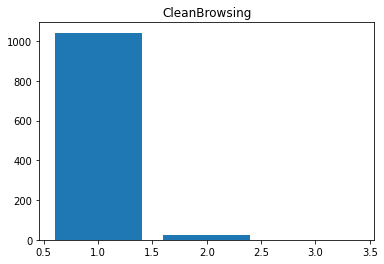

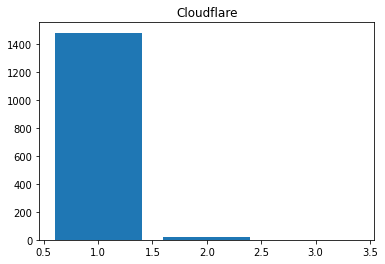

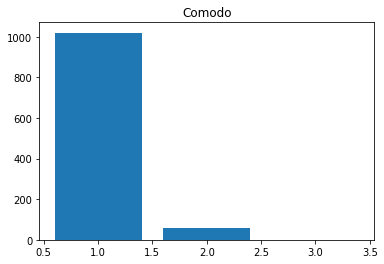

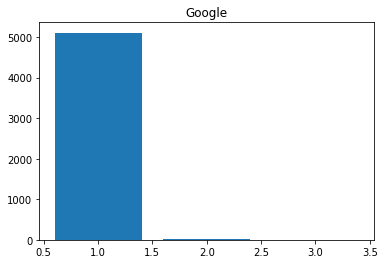

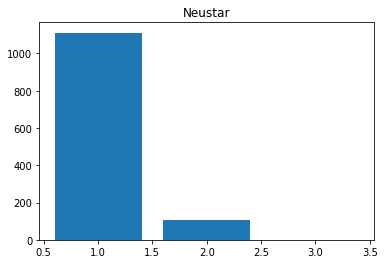

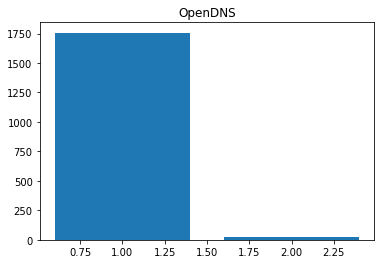

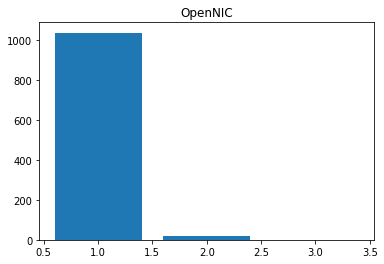

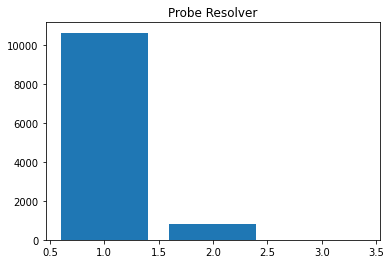

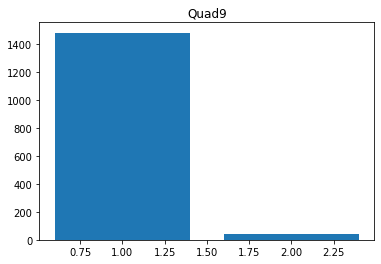

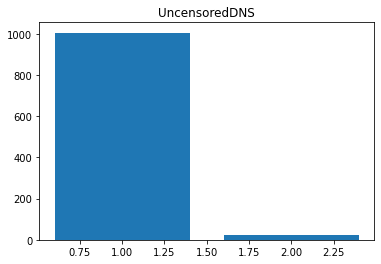

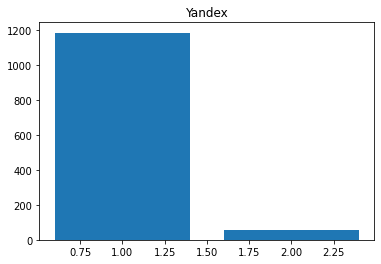

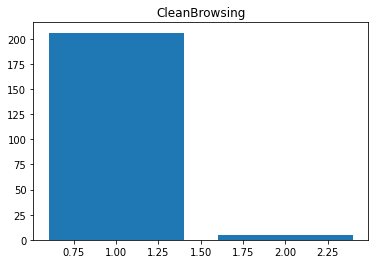

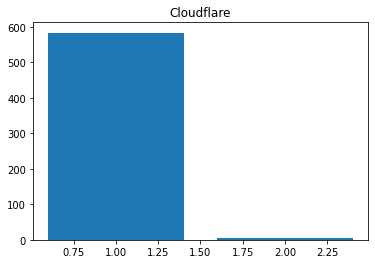

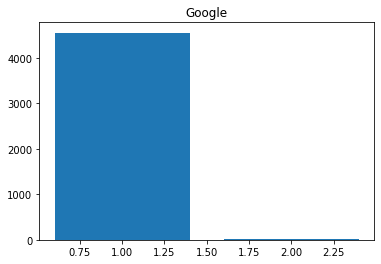

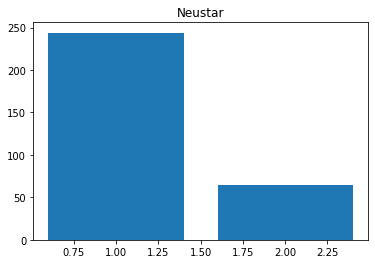

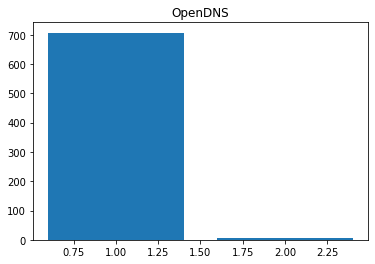

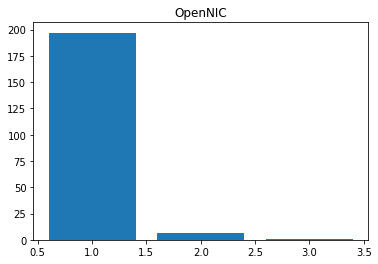

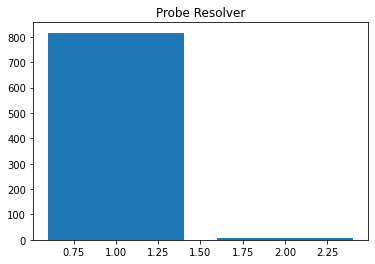

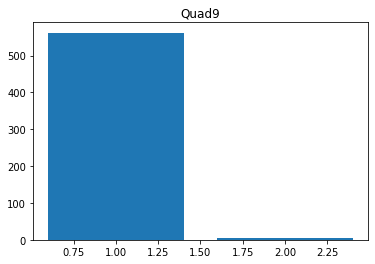

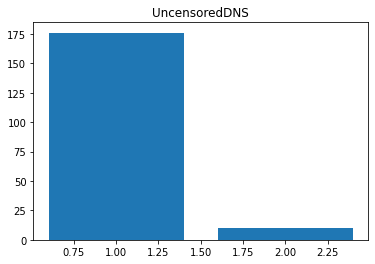

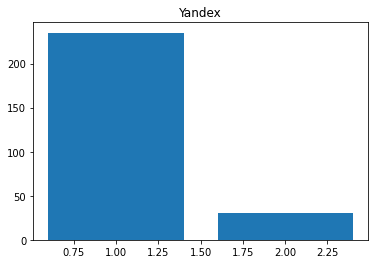

In [26]:
get_different_buffersizes_count(buffersize_data, saver)    

In [31]:
def group_rarely_used_buffersizes(buffersize_data):
    buffersize_data_summarized = [] 
    buffersize_data_ok = []
    for (key, df) in buffersize_data:
        df['backend_udp_size'] = df['backend_udp_size'].map(lambda x: x if x in [512, 1232, 1400, 1410, 1452, 4096, 'None'] else 'other')
        df['frontend_udp_size'] = df['frontend_udp_size'].map(lambda x: x if x in [512, 1232, 1400, 1410, 1452, 4096, 'None'] else 'other')
        buffersize_data_summarized.append((key,df))
        buffersize_data_ok.append((key, df[df['failure'] == 'ok']))

    return buffersize_data_summarized, buffersize_data_ok

In [32]:
buffersize_data_summarized, buffersize_data_ok = group_rarely_used_buffersizes(buffersize_data)

In [33]:
def get_backend_buffersizes(buffersize_data_ok, saver):
    for (key, df) in buffersize_data_ok: 
        print(key)
        ct1 = pd.crosstab(df['backend_udp_size'], df['resolver_protocol'], margins=True)
        ct2 = pd.crosstab(df['backend_udp_size'], df['resolver_protocol'], normalize = 'columns', margins=True).style.format('{:,.2%}')    
        saver.save_table(ct1, f"backend_buffersizes_abs_{key}.csv")
        saver.save_table(ct1, f"backend_buffersizes_rel_{key}.csv")
        display(ct1)
        display(ct2)

In [34]:
get_backend_buffersizes(buffersize_data_ok, saver)

IPv4


resolver_protocol,Probe DoTCP,Probe DoUDP,Public DoTCP,Public DoUDP,All
backend_udp_size,,,,,
512.0,2761,20924,3386,3055,30126
1232.0,9141,60633,519268,478543,1067585
1400.0,14765,35100,153723,153821,357409
1410.0,2413,8104,149243,147356,307116
1452.0,14660,40280,155614,155493,366047
4096.0,6443,27036,408496,433009,874984
other,3025,22510,16280,12946,54761
All,53208,214587,1406010,1384223,3058028


resolver_protocol,Probe DoTCP,Probe DoUDP,Public DoTCP,Public DoUDP,All
backend_udp_size,,,,,
512.0,5.19%,9.75%,0.24%,0.22%,0.99%
1232.0,17.18%,28.26%,36.93%,34.57%,34.91%
1400.0,27.75%,16.36%,10.93%,11.11%,11.69%
1410.0,4.54%,3.78%,10.61%,10.65%,10.04%
1452.0,27.55%,18.77%,11.07%,11.23%,11.97%
4096.0,12.11%,12.60%,29.05%,31.28%,28.61%
other,5.69%,10.49%,1.16%,0.94%,1.79%


IPv6


resolver_protocol,Probe DoTCP,Probe DoUDP,Public DoTCP,Public DoUDP,All
backend_udp_size,,,,,
512.0,130,129,359,1045,1663
1232.0,1405,1543,228235,237843,469026
1400.0,901,905,64908,64646,131360
1410.0,0,0,63865,63594,127459
1452.0,638,689,64217,63037,128581
4096.0,174,180,123622,123663,247639
other,324,400,3679,4677,9080
All,3572,3846,548885,558505,1114808


resolver_protocol,Probe DoTCP,Probe DoUDP,Public DoTCP,Public DoUDP,All
backend_udp_size,,,,,
512.0,3.64%,3.35%,0.07%,0.19%,0.15%
1232.0,39.33%,40.12%,41.58%,42.59%,42.07%
1400.0,25.22%,23.53%,11.83%,11.57%,11.78%
1410.0,0.00%,0.00%,11.64%,11.39%,11.43%
1452.0,17.86%,17.91%,11.70%,11.29%,11.53%
4096.0,4.87%,4.68%,22.52%,22.14%,22.21%
other,9.07%,10.40%,0.67%,0.84%,0.81%


In [56]:
def get_frontend_backend_buffersize_per_resolver(buffersize_data_ok, saver):
    for i in range(len(buffersize_data_ok)): 
        (key, df) = buffersize_data_ok[i]
        #df = df[df["resolver"] != "Comodo"]
        df = df[df["resolver"] != "Probe Resolver"]
        print(key)
        ct_backend = pd.crosstab(df['resolver'], df['backend_udp_size'], normalize = 'index', margins=True).round(4)*100

        ct_frontend = pd.crosstab(df['frontend_udp_size'], df['resolver'], normalize = 'columns', margins=True)

        saver.save_table(ct_backend, f"backend_buffersizes_per_resolver_{key}.csv")
        saver.save_table(ct_frontend, f"frontend_buffersizes_per_resolver_{key}.csv")
        
        display(ct_backend)
        print(ct_backend.to_latex())
        display(ct_frontend)
        
    

In [57]:
get_frontend_backend_buffersize_per_resolver(buffersize_data_ok, saver)

IPv4


backend_udp_size,512.0,1232.0,1400.0,1410.0,1452.0,4096.0,other
resolver,,,,,,,
CleanBrowsing,0.11,98.24,0.45,0.05,0.64,0.36,0.16
Cloudflare,0.36,0.65,0.46,0.04,98.04,0.30,0.16
Comodo,0.11,0.70,0.48,0.05,0.67,95.21,2.78
Google,0.22,0.78,97.86,0.05,0.64,0.27,0.19
Neustar,0.04,0.70,0.48,0.05,0.63,97.45,0.66
OpenDNS,0.08,0.61,0.53,97.68,0.59,0.32,0.19
OpenNIC,0.06,98.29,0.45,0.05,0.59,0.37,0.18
Quad9,0.07,98.05,0.51,0.05,0.70,0.40,0.21
UncensoredDNS,2.68,93.15,1.14,0.12,1.49,0.97,0.45


\begin{tabular}{lrrrrrrr}
\toprule
backend\_udp\_size &  512.0 &  1232.0 &  1400.0 &  1410.0 &  1452.0 &  4096.0 &  other \\
resolver      &        &         &         &         &         &         &        \\
\midrule
CleanBrowsing &   0.11 &   98.24 &    0.45 &    0.05 &    0.64 &    0.36 &   0.16 \\
Cloudflare    &   0.36 &    0.65 &    0.46 &    0.04 &   98.04 &    0.30 &   0.16 \\
Comodo        &   0.11 &    0.70 &    0.48 &    0.05 &    0.67 &   95.21 &   2.78 \\
Google        &   0.22 &    0.78 &   97.86 &    0.05 &    0.64 &    0.27 &   0.19 \\
Neustar       &   0.04 &    0.70 &    0.48 &    0.05 &    0.63 &   97.45 &   0.66 \\
OpenDNS       &   0.08 &    0.61 &    0.53 &   97.68 &    0.59 &    0.32 &   0.19 \\
OpenNIC       &   0.06 &   98.29 &    0.45 &    0.05 &    0.59 &    0.37 &   0.18 \\
Quad9         &   0.07 &   98.05 &    0.51 &    0.05 &    0.70 &    0.40 &   0.21 \\
UncensoredDNS &   2.68 &   93.15 &    1.14 &    0.12 &    1.49 &    0.97 &   0.45 \\
Yandex        & 

resolver,CleanBrowsing,Cloudflare,Comodo,Google,Neustar,OpenDNS,OpenNIC,Quad9,UncensoredDNS,Yandex,All
frontend_udp_size,,,,,,,,,,,
512,0.980421,0.004557,0.004800,0.978666,0.004778,0.005385,0.004541,0.288680,0.011436,0.005503,0.245595
1232,0.009574,0.984082,0.010021,0.010993,0.009439,0.009043,0.985416,0.700356,0.963212,0.009456,0.331230
4096,0.005357,0.005907,0.980232,0.005242,0.980828,0.980687,0.005355,0.005663,0.013510,0.979466,0.417821
None,0.002313,0.002317,0.002440,0.002329,0.002453,0.002315,0.002348,0.002483,0.005883,0.003190,0.002613
other,0.002335,0.003137,0.002507,0.002771,0.002501,0.002570,0.002341,0.002817,0.005958,0.002386,0.002740


IPv6


backend_udp_size,512.0,1232.0,1400.0,1410.0,1452.0,4096.0,other
resolver,,,,,,,
CleanBrowsing,0.01,99.47,0.21,0.00,0.07,0.05,0.19
Cloudflare,0.01,0.26,0.21,0.00,99.38,0.04,0.10
Google,0.02,0.26,99.41,0.00,0.06,0.14,0.10
Neustar,0.02,0.31,0.23,0.00,0.06,98.79,0.60
OpenDNS,0.01,0.26,0.22,99.30,0.07,0.04,0.10
OpenNIC,0.01,99.56,0.23,0.00,0.06,0.05,0.10
Quad9,0.01,99.54,0.22,0.00,0.08,0.04,0.11
UncensoredDNS,1.46,97.91,0.34,0.00,0.08,0.07,0.15
Yandex,0.00,0.26,0.22,0.00,0.06,94.31,5.14


\begin{tabular}{lrrrrrrr}
\toprule
backend\_udp\_size &  512.0 &  1232.0 &  1400.0 &  1410.0 &  1452.0 &  4096.0 &  other \\
resolver      &        &         &         &         &         &         &        \\
\midrule
CleanBrowsing &   0.01 &   99.47 &    0.21 &    0.00 &    0.07 &    0.05 &   0.19 \\
Cloudflare    &   0.01 &    0.26 &    0.21 &    0.00 &   99.38 &    0.04 &   0.10 \\
Google        &   0.02 &    0.26 &   99.41 &    0.00 &    0.06 &    0.14 &   0.10 \\
Neustar       &   0.02 &    0.31 &    0.23 &    0.00 &    0.06 &   98.79 &   0.60 \\
OpenDNS       &   0.01 &    0.26 &    0.22 &   99.30 &    0.07 &    0.04 &   0.10 \\
OpenNIC       &   0.01 &   99.56 &    0.23 &    0.00 &    0.06 &    0.05 &   0.10 \\
Quad9         &   0.01 &   99.54 &    0.22 &    0.00 &    0.08 &    0.04 &   0.11 \\
UncensoredDNS &   1.46 &   97.91 &    0.34 &    0.00 &    0.08 &    0.07 &   0.15 \\
Yandex        &   0.00 &    0.26 &    0.22 &    0.00 &    0.06 &   94.31 &   5.14 \\
All           & 

resolver,CleanBrowsing,Cloudflare,Google,Neustar,OpenDNS,OpenNIC,Quad9,UncensoredDNS,Yandex,All
frontend_udp_size,,,,,,,,,,
512,0.995372,0.002316,0.994322,0.002443,0.002423,0.002481,0.268718,0.003725,0.002370,0.262411
1232,0.001842,0.994913,0.001820,0.001762,0.001792,0.994728,0.728357,0.992208,0.001814,0.390279
4096,0.000998,0.001005,0.002077,0.994011,0.994009,0.001000,0.001049,0.001458,0.994025,0.345452
None,0.001788,0.001766,0.001781,0.001785,0.001776,0.001791,0.001876,0.002609,0.001791,0.001858


# Buffersize dependent on probe continent

In [92]:
def get_buffersize_per_continent_per_resolver(buffersize_data_ok, saver, column_name):
    for (key,df) in buffersize_data_ok: 
        groups = df.groupby("resolver")

        for resolver, group in groups:
            print(resolver)
            ct = pd.crosstab(group["backend_udp_size"], group["continent_code"], normalize="columns")
            saver.save_table(ct, f"{resolver}_backend_udp_sizes_per_continent_{key}.csv")
            display(ct)

In [95]:
get_buffersize_per_continent_per_resolver(buffersize_data_ok, saver, "backend_udp_size")

CleanBrowsing


continent_code,AF,AS,EU,NA,OC,SA
backend_udp_size,,,,,,
512.0,0.000000,0.000832,0.000867,0.001974,0.000000,0.007496
1232.0,0.984363,0.954103,0.984662,0.981668,0.984420,0.969515
1400.0,0.000000,0.013635,0.002989,0.005974,0.008887,0.022989
1410.0,0.000000,0.000000,0.000452,0.000000,0.006254,0.000000
1452.0,0.015637,0.018244,0.005628,0.006721,0.000219,0.000000
4096.0,0.000000,0.012418,0.003990,0.000516,0.000000,0.000000
other,0.000000,0.000768,0.001412,0.003147,0.000219,0.000000


Cloudflare


continent_code,AF,AS,EU,NA,OC,SA
backend_udp_size,,,,,,
512.0,0.000000,0.007031,0.003692,0.002505,0.000000,0.008346
1232.0,0.000508,0.000064,0.006547,0.005065,0.015630,0.034396
1400.0,0.000000,0.013230,0.003019,0.006144,0.011608,0.022762
1410.0,0.000000,0.000000,0.000480,0.000000,0.001954,0.000000
1452.0,0.999492,0.969193,0.981352,0.983141,0.970463,0.934244
4096.0,0.000000,0.006008,0.003814,0.000000,0.000000,0.000000
other,0.000000,0.004474,0.001096,0.003145,0.000345,0.000253


Comodo


continent_code,AF,AS,EU,NA,OC,SA
backend_udp_size,,,,,,
512.0,0.000000,0.000233,0.001091,0.001315,0.000000,0.006332
1232.0,0.000512,0.000389,0.007283,0.004451,0.015462,0.034954
1400.0,0.000000,0.016572,0.003239,0.005965,0.009455,0.023050
1410.0,0.000000,0.000000,0.000513,0.000000,0.005784,0.000000
1452.0,0.016121,0.021085,0.005985,0.006902,0.000111,0.000000
4096.0,0.969294,0.908270,0.968500,0.934821,0.773304,0.899949
other,0.014074,0.053451,0.013389,0.046546,0.195884,0.035714


Google


continent_code,AF,AS,EU,NA,OC,SA
backend_udp_size,,,,,,
512.0,0.000000,0.002276,0.002184,0.002266,0.000000,0.007576
1232.0,0.000508,0.000063,0.008357,0.005166,0.015369,0.034596
1400.0,0.983486,0.965358,0.978777,0.982452,0.978529,0.957828
1410.0,0.000000,0.000000,0.000451,0.000000,0.004972,0.000000
1452.0,0.016006,0.017321,0.005670,0.006816,0.000904,0.000000
4096.0,0.000000,0.010494,0.002955,0.000199,0.000000,0.000000
other,0.000000,0.004488,0.001607,0.003100,0.000226,0.000000


Neustar


continent_code,AF,AS,EU,NA,OC,SA
backend_udp_size,,,,,,
512.0,0.000000,0.000070,0.000185,0.000950,0.000000,0.006823
1232.0,0.001066,0.000911,0.007167,0.004620,0.016374,0.037937
1400.0,0.000000,0.014863,0.003190,0.006110,0.010760,0.025109
1410.0,0.000000,0.000000,0.000456,0.000000,0.005614,0.000000
1452.0,0.017329,0.019980,0.005259,0.007489,0.000000,0.000000
4096.0,0.973874,0.955763,0.978232,0.970753,0.959298,0.925764
other,0.007731,0.008413,0.005511,0.010078,0.007953,0.004367


OpenDNS


continent_code,AF,AS,EU,NA,OC,SA
backend_udp_size,,,,,,
512.0,0.000000,0.000127,0.000491,0.001675,0.000000,0.007083
1232.0,0.000254,0.000573,0.006651,0.004898,0.015253,0.000000
1400.0,0.000000,0.013495,0.004242,0.005907,0.008350,0.022768
1410.0,0.983511,0.950923,0.978653,0.976950,0.975729,0.970149
1452.0,0.016235,0.017441,0.004939,0.006717,0.000668,0.000000
4096.0,0.000000,0.012794,0.003438,0.000810,0.000000,0.000000
other,0.000000,0.004647,0.001586,0.003043,0.000000,0.000000


OpenNIC


continent_code,AF,AS,EU,NA,OC,SA
backend_udp_size,,,,,,
512.0,0.000000,0.000193,0.000329,0.001462,0.000000,0.007234
1232.0,0.983924,0.954259,0.985464,0.981599,0.984085,0.969818
1400.0,0.000000,0.013639,0.003041,0.006009,0.008639,0.022948
1410.0,0.000000,0.000000,0.000445,0.000000,0.006593,0.000000
1452.0,0.016076,0.018335,0.004988,0.006793,0.000682,0.000000
4096.0,0.000000,0.013188,0.004074,0.001034,0.000000,0.000000
other,0.000000,0.000386,0.001659,0.003102,0.000000,0.000000


Probe Resolver


continent_code,AF,AS,EU,NA,OC,SA
backend_udp_size,,,,,,
512.0,0.031210,0.141117,0.091282,0.065880,0.033501,0.174865
1232.0,0.176319,0.139793,0.296612,0.197602,0.166446,0.113042
1400.0,0.206242,0.267673,0.166198,0.226618,0.265493,0.159522
1410.0,0.000000,0.052820,0.038569,0.039263,0.032177,0.003836
1452.0,0.280245,0.165475,0.199171,0.226915,0.319915,0.100406
4096.0,0.014157,0.168321,0.103053,0.170925,0.159031,0.411552
other,0.291828,0.064800,0.105115,0.072798,0.023438,0.036778


Quad9


continent_code,AF,AS,EU,NA,OC,SA
backend_udp_size,,,,,,
512.0,0.000000,0.002161,0.000276,0.001510,0.000000,0.007338
1232.0,0.982013,0.929663,0.984207,0.978881,0.980756,0.969340
1400.0,0.000000,0.023366,0.003143,0.006722,0.011659,0.023323
1410.0,0.000000,0.000000,0.000469,0.000000,0.006743,0.000000
1452.0,0.017987,0.023606,0.005871,0.008067,0.000843,0.000000
4096.0,0.000000,0.015604,0.004268,0.001324,0.000000,0.000000
other,0.000000,0.005601,0.001766,0.003496,0.000000,0.000000


UncensoredDNS


continent_code,AF,AS,EU,NA,OC,SA
backend_udp_size,,,,,,
512.0,0.014108,0.017752,0.027771,0.028008,0.017370,0.032258
1232.0,0.932780,0.887347,0.936687,0.923453,0.948139,0.913783
1400.0,0.000000,0.028430,0.007562,0.016396,0.022581,0.053959
1410.0,0.000000,0.000000,0.001181,0.000000,0.011414,0.000000
1452.0,0.053112,0.037907,0.012368,0.019336,0.000496,0.000000
4096.0,0.000000,0.027096,0.010226,0.004087,0.000000,0.000000
other,0.000000,0.001468,0.004204,0.008721,0.000000,0.000000


Yandex


continent_code,AF,AS,EU,NA,OC,SA
backend_udp_size,,,,,,
512.0,0.000000,0.000128,0.000116,0.000972,0.000000,0.006202
1232.0,0.000250,0.000511,0.006819,0.004147,0.015381,0.035659
1400.0,0.000000,0.015711,0.004346,0.005982,0.010987,0.023773
1410.0,0.000000,0.000000,0.000438,0.000000,0.004065,0.000000
1452.0,0.016012,0.025227,0.005655,0.007303,0.000330,0.000000
4096.0,0.931449,0.904586,0.931190,0.929488,0.918260,0.889922
other,0.052289,0.053838,0.051435,0.052109,0.050978,0.044444


CleanBrowsing


continent_code,AF,AS,EU,NA,OC,SA
backend_udp_size,,,,,,
512.0,0.0,0.000000,0.000000,0.000504,0.000000,0.000000
1232.0,1.0,0.998974,0.996193,0.989005,0.999642,0.958142
1400.0,0.0,0.000000,0.000484,0.007010,0.000000,0.041858
1452.0,0.0,0.000000,0.000947,0.000000,0.000000,0.000000
4096.0,0.0,0.000000,0.000000,0.003026,0.000000,0.000000
other,0.0,0.001026,0.002377,0.000454,0.000358,0.000000


Cloudflare


continent_code,AF,AS,EU,NA,OC,SA
backend_udp_size,,,,,,
512.0,0.0,0.000000,0.000000,0.000766,0.0000,0.000000
1232.0,0.0,0.018068,0.000000,0.003472,0.0498,0.000000
1400.0,0.0,0.000000,0.000429,0.006996,0.0000,0.044345
1452.0,1.0,0.981932,0.998230,0.986060,0.9502,0.955655
4096.0,0.0,0.000000,0.000000,0.002706,0.0000,0.000000
other,0.0,0.000000,0.001340,0.000000,0.0000,0.000000


Google


continent_code,AF,AS,EU,NA,OC,SA
backend_udp_size,,,,,,
512.0,0.0,0.000000,0.000052,0.001174,0.000000,0.000000
1232.0,0.0,0.018066,0.000000,0.003521,0.050218,0.000000
1400.0,1.0,0.981934,0.996367,0.992958,0.949782,0.999505
1452.0,0.0,0.000000,0.000864,0.000000,0.000000,0.000000
4096.0,0.0,0.000000,0.001384,0.002347,0.000000,0.000000
other,0.0,0.000000,0.001332,0.000000,0.000000,0.000495


Neustar


continent_code,AF,AS,EU,NA,OC,SA
backend_udp_size,,,,,,
512.0,0.000000,0.000000,0.000000,0.001385,0.000000,0.000000
1232.0,0.000000,0.019980,0.000209,0.004925,0.049097,0.000463
1400.0,0.000000,0.000000,0.000637,0.007080,0.000000,0.041705
1452.0,0.000000,0.000000,0.000804,0.000000,0.000000,0.000000
4096.0,0.998172,0.972145,0.992910,0.979068,0.941877,0.952734
other,0.001828,0.007875,0.005441,0.007542,0.009025,0.005097


OpenDNS


continent_code,AF,AS,EU,NA,OC,SA
backend_udp_size,,,,,,
512.0,0.0,0.00000,0.000000,0.000715,0.000000,0.000000
1232.0,0.0,0.01839,0.000000,0.003522,0.049766,0.000000
1400.0,0.0,0.00000,0.000551,0.007045,0.000000,0.041744
1410.0,1.0,0.98161,0.997247,0.985910,0.950234,0.958256
1452.0,0.0,0.00000,0.000883,0.000000,0.000000,0.000000
4096.0,0.0,0.00000,0.000000,0.002808,0.000000,0.000000
other,0.0,0.00000,0.001320,0.000000,0.000000,0.000000


OpenNIC


continent_code,AF,AS,EU,NA,OC,SA
backend_udp_size,,,,,,
512.0,0.0,0.0,0.000000,0.000507,0.0,0.000000
1232.0,1.0,1.0,0.997235,0.989460,1.0,0.958103
1400.0,0.0,0.0,0.000629,0.007044,0.0,0.041897
1452.0,0.0,0.0,0.000805,0.000000,0.0,0.000000
4096.0,0.0,0.0,0.000000,0.002990,0.0,0.000000
other,0.0,0.0,0.001331,0.000000,0.0,0.000000


Probe Resolver


continent_code,AS,EU,NA,OC,SA
backend_udp_size,,,,,
512.0,0.009639,0.038456,0.000000,0.0,1.0
1232.0,0.014458,0.446876,0.004751,0.0,0.0
1400.0,0.640964,0.233926,0.000000,1.0,0.0
1452.0,0.000000,0.180727,0.327791,0.0,0.0
4096.0,0.000000,0.011248,0.665083,0.0,0.0
other,0.334940,0.088767,0.002375,0.0,0.0


Quad9


continent_code,AF,AS,EU,NA,OC,SA
backend_udp_size,,,,,,
512.0,0.0,0.0,0.000000,0.000861,0.000000,0.00000
1232.0,1.0,1.0,0.997185,0.988123,0.999518,0.95671
1400.0,0.0,0.0,0.000455,0.007918,0.000000,0.04329
1452.0,0.0,0.0,0.001005,0.000000,0.000000,0.00000
4096.0,0.0,0.0,0.000000,0.003098,0.000000,0.00000
other,0.0,0.0,0.001355,0.000000,0.000482,0.00000


UncensoredDNS


continent_code,AF,AS,EU,NA,OC,SA
backend_udp_size,,,,,,
512.0,0.004065,0.009247,0.015007,0.016104,0.005663,0.006901
1232.0,0.995935,0.990753,0.981162,0.966172,0.993528,0.941346
1400.0,0.000000,0.000000,0.001008,0.012416,0.000000,0.051754
1452.0,0.000000,0.000000,0.000979,0.000000,0.000000,0.000000
4096.0,0.000000,0.000000,0.000000,0.005308,0.000000,0.000000
other,0.000000,0.000000,0.001844,0.000000,0.000809,0.000000


Yandex


continent_code,AF,AS,EU,NA,OC,SA
backend_udp_size,,,,,,
512.0,0.000000,0.000000,0.000000,0.000263,0.000000,0.000000
1232.0,0.000000,0.018166,0.000000,0.003629,0.049080,0.000000
1400.0,0.000000,0.000000,0.000569,0.007259,0.000000,0.041667
1452.0,0.000000,0.000000,0.000858,0.000000,0.000000,0.000000
4096.0,0.959854,0.930143,0.946865,0.939775,0.891375,0.907407
other,0.040146,0.051691,0.051708,0.049074,0.059545,0.050926


In [96]:
get_buffersize_per_continent_per_resolver(buffersize_data_ok, saver, "frontend_udp_size")

CleanBrowsing


continent_code,AF,AS,EU,NA,OC,SA
backend_udp_size,,,,,,
512.0,0.000000,0.000832,0.000867,0.001974,0.000000,0.007496
1232.0,0.984363,0.954103,0.984662,0.981668,0.984420,0.969515
1400.0,0.000000,0.013635,0.002989,0.005974,0.008887,0.022989
1410.0,0.000000,0.000000,0.000452,0.000000,0.006254,0.000000
1452.0,0.015637,0.018244,0.005628,0.006721,0.000219,0.000000
4096.0,0.000000,0.012418,0.003990,0.000516,0.000000,0.000000
other,0.000000,0.000768,0.001412,0.003147,0.000219,0.000000


Cloudflare


continent_code,AF,AS,EU,NA,OC,SA
backend_udp_size,,,,,,
512.0,0.000000,0.007031,0.003692,0.002505,0.000000,0.008346
1232.0,0.000508,0.000064,0.006547,0.005065,0.015630,0.034396
1400.0,0.000000,0.013230,0.003019,0.006144,0.011608,0.022762
1410.0,0.000000,0.000000,0.000480,0.000000,0.001954,0.000000
1452.0,0.999492,0.969193,0.981352,0.983141,0.970463,0.934244
4096.0,0.000000,0.006008,0.003814,0.000000,0.000000,0.000000
other,0.000000,0.004474,0.001096,0.003145,0.000345,0.000253


Comodo


continent_code,AF,AS,EU,NA,OC,SA
backend_udp_size,,,,,,
512.0,0.000000,0.000233,0.001091,0.001315,0.000000,0.006332
1232.0,0.000512,0.000389,0.007283,0.004451,0.015462,0.034954
1400.0,0.000000,0.016572,0.003239,0.005965,0.009455,0.023050
1410.0,0.000000,0.000000,0.000513,0.000000,0.005784,0.000000
1452.0,0.016121,0.021085,0.005985,0.006902,0.000111,0.000000
4096.0,0.969294,0.908270,0.968500,0.934821,0.773304,0.899949
other,0.014074,0.053451,0.013389,0.046546,0.195884,0.035714


Google


continent_code,AF,AS,EU,NA,OC,SA
backend_udp_size,,,,,,
512.0,0.000000,0.002276,0.002184,0.002266,0.000000,0.007576
1232.0,0.000508,0.000063,0.008357,0.005166,0.015369,0.034596
1400.0,0.983486,0.965358,0.978777,0.982452,0.978529,0.957828
1410.0,0.000000,0.000000,0.000451,0.000000,0.004972,0.000000
1452.0,0.016006,0.017321,0.005670,0.006816,0.000904,0.000000
4096.0,0.000000,0.010494,0.002955,0.000199,0.000000,0.000000
other,0.000000,0.004488,0.001607,0.003100,0.000226,0.000000


Neustar


continent_code,AF,AS,EU,NA,OC,SA
backend_udp_size,,,,,,
512.0,0.000000,0.000070,0.000185,0.000950,0.000000,0.006823
1232.0,0.001066,0.000911,0.007167,0.004620,0.016374,0.037937
1400.0,0.000000,0.014863,0.003190,0.006110,0.010760,0.025109
1410.0,0.000000,0.000000,0.000456,0.000000,0.005614,0.000000
1452.0,0.017329,0.019980,0.005259,0.007489,0.000000,0.000000
4096.0,0.973874,0.955763,0.978232,0.970753,0.959298,0.925764
other,0.007731,0.008413,0.005511,0.010078,0.007953,0.004367


OpenDNS


continent_code,AF,AS,EU,NA,OC,SA
backend_udp_size,,,,,,
512.0,0.000000,0.000127,0.000491,0.001675,0.000000,0.007083
1232.0,0.000254,0.000573,0.006651,0.004898,0.015253,0.000000
1400.0,0.000000,0.013495,0.004242,0.005907,0.008350,0.022768
1410.0,0.983511,0.950923,0.978653,0.976950,0.975729,0.970149
1452.0,0.016235,0.017441,0.004939,0.006717,0.000668,0.000000
4096.0,0.000000,0.012794,0.003438,0.000810,0.000000,0.000000
other,0.000000,0.004647,0.001586,0.003043,0.000000,0.000000


OpenNIC


continent_code,AF,AS,EU,NA,OC,SA
backend_udp_size,,,,,,
512.0,0.000000,0.000193,0.000329,0.001462,0.000000,0.007234
1232.0,0.983924,0.954259,0.985464,0.981599,0.984085,0.969818
1400.0,0.000000,0.013639,0.003041,0.006009,0.008639,0.022948
1410.0,0.000000,0.000000,0.000445,0.000000,0.006593,0.000000
1452.0,0.016076,0.018335,0.004988,0.006793,0.000682,0.000000
4096.0,0.000000,0.013188,0.004074,0.001034,0.000000,0.000000
other,0.000000,0.000386,0.001659,0.003102,0.000000,0.000000


Probe Resolver


continent_code,AF,AS,EU,NA,OC,SA
backend_udp_size,,,,,,
512.0,0.031210,0.141117,0.091282,0.065880,0.033501,0.174865
1232.0,0.176319,0.139793,0.296612,0.197602,0.166446,0.113042
1400.0,0.206242,0.267673,0.166198,0.226618,0.265493,0.159522
1410.0,0.000000,0.052820,0.038569,0.039263,0.032177,0.003836
1452.0,0.280245,0.165475,0.199171,0.226915,0.319915,0.100406
4096.0,0.014157,0.168321,0.103053,0.170925,0.159031,0.411552
other,0.291828,0.064800,0.105115,0.072798,0.023438,0.036778


Quad9


continent_code,AF,AS,EU,NA,OC,SA
backend_udp_size,,,,,,
512.0,0.000000,0.002161,0.000276,0.001510,0.000000,0.007338
1232.0,0.982013,0.929663,0.984207,0.978881,0.980756,0.969340
1400.0,0.000000,0.023366,0.003143,0.006722,0.011659,0.023323
1410.0,0.000000,0.000000,0.000469,0.000000,0.006743,0.000000
1452.0,0.017987,0.023606,0.005871,0.008067,0.000843,0.000000
4096.0,0.000000,0.015604,0.004268,0.001324,0.000000,0.000000
other,0.000000,0.005601,0.001766,0.003496,0.000000,0.000000


UncensoredDNS


continent_code,AF,AS,EU,NA,OC,SA
backend_udp_size,,,,,,
512.0,0.014108,0.017752,0.027771,0.028008,0.017370,0.032258
1232.0,0.932780,0.887347,0.936687,0.923453,0.948139,0.913783
1400.0,0.000000,0.028430,0.007562,0.016396,0.022581,0.053959
1410.0,0.000000,0.000000,0.001181,0.000000,0.011414,0.000000
1452.0,0.053112,0.037907,0.012368,0.019336,0.000496,0.000000
4096.0,0.000000,0.027096,0.010226,0.004087,0.000000,0.000000
other,0.000000,0.001468,0.004204,0.008721,0.000000,0.000000


Yandex


continent_code,AF,AS,EU,NA,OC,SA
backend_udp_size,,,,,,
512.0,0.000000,0.000128,0.000116,0.000972,0.000000,0.006202
1232.0,0.000250,0.000511,0.006819,0.004147,0.015381,0.035659
1400.0,0.000000,0.015711,0.004346,0.005982,0.010987,0.023773
1410.0,0.000000,0.000000,0.000438,0.000000,0.004065,0.000000
1452.0,0.016012,0.025227,0.005655,0.007303,0.000330,0.000000
4096.0,0.931449,0.904586,0.931190,0.929488,0.918260,0.889922
other,0.052289,0.053838,0.051435,0.052109,0.050978,0.044444


CleanBrowsing


continent_code,AF,AS,EU,NA,OC,SA
backend_udp_size,,,,,,
512.0,0.0,0.000000,0.000000,0.000504,0.000000,0.000000
1232.0,1.0,0.998974,0.996193,0.989005,0.999642,0.958142
1400.0,0.0,0.000000,0.000484,0.007010,0.000000,0.041858
1452.0,0.0,0.000000,0.000947,0.000000,0.000000,0.000000
4096.0,0.0,0.000000,0.000000,0.003026,0.000000,0.000000
other,0.0,0.001026,0.002377,0.000454,0.000358,0.000000


Cloudflare


continent_code,AF,AS,EU,NA,OC,SA
backend_udp_size,,,,,,
512.0,0.0,0.000000,0.000000,0.000766,0.0000,0.000000
1232.0,0.0,0.018068,0.000000,0.003472,0.0498,0.000000
1400.0,0.0,0.000000,0.000429,0.006996,0.0000,0.044345
1452.0,1.0,0.981932,0.998230,0.986060,0.9502,0.955655
4096.0,0.0,0.000000,0.000000,0.002706,0.0000,0.000000
other,0.0,0.000000,0.001340,0.000000,0.0000,0.000000


Google


continent_code,AF,AS,EU,NA,OC,SA
backend_udp_size,,,,,,
512.0,0.0,0.000000,0.000052,0.001174,0.000000,0.000000
1232.0,0.0,0.018066,0.000000,0.003521,0.050218,0.000000
1400.0,1.0,0.981934,0.996367,0.992958,0.949782,0.999505
1452.0,0.0,0.000000,0.000864,0.000000,0.000000,0.000000
4096.0,0.0,0.000000,0.001384,0.002347,0.000000,0.000000
other,0.0,0.000000,0.001332,0.000000,0.000000,0.000495


Neustar


continent_code,AF,AS,EU,NA,OC,SA
backend_udp_size,,,,,,
512.0,0.000000,0.000000,0.000000,0.001385,0.000000,0.000000
1232.0,0.000000,0.019980,0.000209,0.004925,0.049097,0.000463
1400.0,0.000000,0.000000,0.000637,0.007080,0.000000,0.041705
1452.0,0.000000,0.000000,0.000804,0.000000,0.000000,0.000000
4096.0,0.998172,0.972145,0.992910,0.979068,0.941877,0.952734
other,0.001828,0.007875,0.005441,0.007542,0.009025,0.005097


OpenDNS


continent_code,AF,AS,EU,NA,OC,SA
backend_udp_size,,,,,,
512.0,0.0,0.00000,0.000000,0.000715,0.000000,0.000000
1232.0,0.0,0.01839,0.000000,0.003522,0.049766,0.000000
1400.0,0.0,0.00000,0.000551,0.007045,0.000000,0.041744
1410.0,1.0,0.98161,0.997247,0.985910,0.950234,0.958256
1452.0,0.0,0.00000,0.000883,0.000000,0.000000,0.000000
4096.0,0.0,0.00000,0.000000,0.002808,0.000000,0.000000
other,0.0,0.00000,0.001320,0.000000,0.000000,0.000000


OpenNIC


continent_code,AF,AS,EU,NA,OC,SA
backend_udp_size,,,,,,
512.0,0.0,0.0,0.000000,0.000507,0.0,0.000000
1232.0,1.0,1.0,0.997235,0.989460,1.0,0.958103
1400.0,0.0,0.0,0.000629,0.007044,0.0,0.041897
1452.0,0.0,0.0,0.000805,0.000000,0.0,0.000000
4096.0,0.0,0.0,0.000000,0.002990,0.0,0.000000
other,0.0,0.0,0.001331,0.000000,0.0,0.000000


Probe Resolver


continent_code,AS,EU,NA,OC,SA
backend_udp_size,,,,,
512.0,0.009639,0.038456,0.000000,0.0,1.0
1232.0,0.014458,0.446876,0.004751,0.0,0.0
1400.0,0.640964,0.233926,0.000000,1.0,0.0
1452.0,0.000000,0.180727,0.327791,0.0,0.0
4096.0,0.000000,0.011248,0.665083,0.0,0.0
other,0.334940,0.088767,0.002375,0.0,0.0


Quad9


continent_code,AF,AS,EU,NA,OC,SA
backend_udp_size,,,,,,
512.0,0.0,0.0,0.000000,0.000861,0.000000,0.00000
1232.0,1.0,1.0,0.997185,0.988123,0.999518,0.95671
1400.0,0.0,0.0,0.000455,0.007918,0.000000,0.04329
1452.0,0.0,0.0,0.001005,0.000000,0.000000,0.00000
4096.0,0.0,0.0,0.000000,0.003098,0.000000,0.00000
other,0.0,0.0,0.001355,0.000000,0.000482,0.00000


UncensoredDNS


continent_code,AF,AS,EU,NA,OC,SA
backend_udp_size,,,,,,
512.0,0.004065,0.009247,0.015007,0.016104,0.005663,0.006901
1232.0,0.995935,0.990753,0.981162,0.966172,0.993528,0.941346
1400.0,0.000000,0.000000,0.001008,0.012416,0.000000,0.051754
1452.0,0.000000,0.000000,0.000979,0.000000,0.000000,0.000000
4096.0,0.000000,0.000000,0.000000,0.005308,0.000000,0.000000
other,0.000000,0.000000,0.001844,0.000000,0.000809,0.000000


Yandex


continent_code,AF,AS,EU,NA,OC,SA
backend_udp_size,,,,,,
512.0,0.000000,0.000000,0.000000,0.000263,0.000000,0.000000
1232.0,0.000000,0.018166,0.000000,0.003629,0.049080,0.000000
1400.0,0.000000,0.000000,0.000569,0.007259,0.000000,0.041667
1452.0,0.000000,0.000000,0.000858,0.000000,0.000000,0.000000
4096.0,0.959854,0.930143,0.946865,0.939775,0.891375,0.907407
other,0.040146,0.051691,0.051708,0.049074,0.059545,0.050926


In [78]:
def get_frontend_backend_proto(buffersize_data_ok, saver):
    for i in range(len(buffersize_data_ok)): 
        (key, df) = buffersize_data_ok[i]
        df = df[df["resolver"] != "Public Resolver"]
        df = df[df["resolver"] != "Comodo"]
        print(key)
        ct = pd.crosstab(df['backend_proto'].append(pd.Series(["TCP"]), ignore_index=True), df['proto'])
        ct_normalized = pd.crosstab(df['backend_proto'].append(pd.Series(["TCP"]), ignore_index=True), df['proto'], normalize = 'columns')

        saver.save_table(ct, f"frontend_vs_backend_proto_abs_{key}.csv")
        saver.save_table(ct, f"frontend_vs_backend_proto_rel_{key}.csv")
        display(ct)
        display(ct_normalized)

In [79]:
get_frontend_backend_proto(buffersize_data_ok, saver)

IPv4


proto,TCP,UDP
row_0,,
TCP,3,4
UDP,1038985,1141327


proto,TCP,UDP
row_0,,
TCP,0.000003,0.000004
UDP,0.999997,0.999996


IPv6


proto,TCP,UDP
row_0,,
TCP,1,0
UDP,492861,502037


proto,TCP,UDP
row_0,,
TCP,0.000002,0.0
UDP,0.999998,1.0


# Backend resolvers

In [37]:
buffersize_data_with_backend = get_edns_data_with_backend(buffersize_data, db)

In [328]:
def get_top_backend_ases_for_resolvers(buffersize_data_with_backend, saver):
    for key, df in buffersize_data_with_backend:
        groups = df.groupby("resolver")
        for resolver, group in groups:
            print(resolver)
            df = group.value_counts("as_name_backend", normalize=False).to_frame("count").head(10)
            saver.save_table(df, f"top_backend_ases_abs_{resolver}_{key}.csv")
            display(df)
            df = group.value_counts("as_name_backend", normalize=True).to_frame("percentage").head(10)
            saver.save_table(df, f"top_backend_ases_rel_{resolver}_{key}.csv")
            display(df)

In [329]:
get_top_backend_ases_for_resolvers(buffersize_data_with_backend, saver)

CleanBrowsing


,count
as_name_backend,
"AS-CHOOPA - Choopa, LLC",203845
COGENT-174 - Cogent Communications,87378
MELBICOM-EU-AS Melbikomas UAB,4305
ASDETUK http://www.heficed.com,3168
"CLOUDFLARENET - Cloudflare, Inc.",1947
GOOGLE - Google LLC,1370
"COMCAST-7922 - Comcast Cable Communications, LLC",310
FASTWEB,228
CLOUDWEBMANAGE-,212


,percentage
as_name_backend,
"AS-CHOOPA - Choopa, LLC",0.666271
COGENT-174 - Cogent Communications,0.285597
MELBICOM-EU-AS Melbikomas UAB,0.014071
ASDETUK http://www.heficed.com,0.010355
"CLOUDFLARENET - Cloudflare, Inc.",0.006364
GOOGLE - Google LLC,0.004478
"COMCAST-7922 - Comcast Cable Communications, LLC",0.001013
FASTWEB,0.000745
CLOUDWEBMANAGE-,0.000693


Cloudflare


,count
as_name_backend,
"CLOUDFLARENET - Cloudflare, Inc.",294370
GOOGLE - Google LLC,1376
"COMCAST-7922 - Comcast Cable Communications, LLC",305
FASTWEB,227
VODAFONE-CZ-AS,204
"AS-CHOOPA - Choopa, LLC",170
VODAFONE_ES,165
WOODYNET-1 - WoodyNet,143
RCS-RDS 73-75 Dr. Staicovici,138


,percentage
as_name_backend,
"CLOUDFLARENET - Cloudflare, Inc.",0.980995
GOOGLE - Google LLC,0.004586
"COMCAST-7922 - Comcast Cable Communications, LLC",0.001016
FASTWEB,0.000756
VODAFONE-CZ-AS,0.000680
"AS-CHOOPA - Choopa, LLC",0.000567
VODAFONE_ES,0.000550
WOODYNET-1 - WoodyNet,0.000477
RCS-RDS 73-75 Dr. Staicovici,0.000460


Comodo


,count
as_name_backend,
"AS-CHOOPA - Choopa, LLC",271973
"CLOUDFLARENET - Cloudflare, Inc.",1908
GOOGLE - Google LLC,1364
"COMCAST-7922 - Comcast Cable Communications, LLC",306
UCOMINT,252
FASTWEB,227
VODAFONE-CZ-AS,203
WOODYNET-1 - WoodyNet,164
"OPENDNS - Cisco OpenDNS, LLC",154


,percentage
as_name_backend,
"AS-CHOOPA - Choopa, LLC",0.974873
"CLOUDFLARENET - Cloudflare, Inc.",0.006839
GOOGLE - Google LLC,0.004889
"COMCAST-7922 - Comcast Cable Communications, LLC",0.001097
UCOMINT,0.000903
FASTWEB,0.000814
VODAFONE-CZ-AS,0.000728
WOODYNET-1 - WoodyNet,0.000588
"OPENDNS - Cisco OpenDNS, LLC",0.000552


Google


,count
as_name_backend,
GOOGLE - Google LLC,294623
"CLOUDFLARENET - Cloudflare, Inc.",1928
"COMCAST-7922 - Comcast Cable Communications, LLC",304
AS20712 Andrews & Arnold Ltd,276
WOODYNET-1 - WoodyNet,265
FASTWEB,218
VODAFONE-CZ-AS,205
"AS-CHOOPA - Choopa, LLC",171
"OPENDNS - Cisco OpenDNS, LLC",140


,percentage
as_name_backend,
GOOGLE - Google LLC,0.979195
"CLOUDFLARENET - Cloudflare, Inc.",0.006408
"COMCAST-7922 - Comcast Cable Communications, LLC",0.001010
AS20712 Andrews & Arnold Ltd,0.000917
WOODYNET-1 - WoodyNet,0.000881
FASTWEB,0.000725
VODAFONE-CZ-AS,0.000681
"AS-CHOOPA - Choopa, LLC",0.000568
"OPENDNS - Cisco OpenDNS, LLC",0.000465


Neustar


,count
as_name_backend,
"ULTRADNS - NeuStar, Inc.",275142
"NEUSTAR-AS6 - NeuStar, Inc.",7949
"CLOUDFLARENET - Cloudflare, Inc.",1835
GOOGLE - Google LLC,1381
"COMCAST-7922 - Comcast Cable Communications, LLC",309
FASTWEB,221
VODAFONE-CZ-AS,206
"AS-CHOOPA - Choopa, LLC",176
WOODYNET-1 - WoodyNet,160


,percentage
as_name_backend,
"ULTRADNS - NeuStar, Inc.",0.948520
"NEUSTAR-AS6 - NeuStar, Inc.",0.027403
"CLOUDFLARENET - Cloudflare, Inc.",0.006326
GOOGLE - Google LLC,0.004761
"COMCAST-7922 - Comcast Cable Communications, LLC",0.001065
FASTWEB,0.000762
VODAFONE-CZ-AS,0.000710
"AS-CHOOPA - Choopa, LLC",0.000607
WOODYNET-1 - WoodyNet,0.000552


OpenDNS


,count
as_name_backend,
"OPENDNS - Cisco OpenDNS, LLC",295313
"CLOUDFLARENET - Cloudflare, Inc.",1773
GOOGLE - Google LLC,1612
"COMCAST-7922 - Comcast Cable Communications, LLC",306
FASTWEB,219
VODAFONE-CZ-AS,204
"AS-CHOOPA - Choopa, LLC",172
CDN77,138
AS20712 Andrews & Arnold Ltd,138


,percentage
as_name_backend,
"OPENDNS - Cisco OpenDNS, LLC",0.977408
"CLOUDFLARENET - Cloudflare, Inc.",0.005868
GOOGLE - Google LLC,0.005335
"COMCAST-7922 - Comcast Cable Communications, LLC",0.001013
FASTWEB,0.000725
VODAFONE-CZ-AS,0.000675
"AS-CHOOPA - Choopa, LLC",0.000569
CDN77,0.000457
AS20712 Andrews & Arnold Ltd,0.000457


OpenNIC


,count
as_name_backend,
"AS-CHOOPA - Choopa, LLC",267784
MYTHIC Mythic Beasts Ltd,29769
"CLOUDFLARENET - Cloudflare, Inc.",1812
GOOGLE - Google LLC,1373
"COMCAST-7922 - Comcast Cable Communications, LLC",310
FASTWEB,220
VODAFONE-CZ-AS,207
WOODYNET-1 - WoodyNet,161
"OPENDNS - Cisco OpenDNS, LLC",154


,percentage
as_name_backend,
"AS-CHOOPA - Choopa, LLC",0.879792
MYTHIC Mythic Beasts Ltd,0.097805
"CLOUDFLARENET - Cloudflare, Inc.",0.005953
GOOGLE - Google LLC,0.004511
"COMCAST-7922 - Comcast Cable Communications, LLC",0.001018
FASTWEB,0.000723
VODAFONE-CZ-AS,0.000680
WOODYNET-1 - WoodyNet,0.000529
"OPENDNS - Cisco OpenDNS, LLC",0.000506


Probe Resolver


,count
as_name_backend,
"CLOUDFLARENET - Cloudflare, Inc.",52944
GOOGLE - Google LLC,48684
"OPENDNS - Cisco OpenDNS, LLC",10028
WOODYNET-1 - WoodyNet,9306
DTAG Internet service provider operations,8065
PROXAD,7907
"COMCAST-7922 - Comcast Cable Communications, LLC",6998
AS3215,6085
VODANET International IP-Backbone of Vodafone,5941


,percentage
as_name_backend,
"CLOUDFLARENET - Cloudflare, Inc.",0.196192
GOOGLE - Google LLC,0.180406
"OPENDNS - Cisco OpenDNS, LLC",0.037160
WOODYNET-1 - WoodyNet,0.034485
DTAG Internet service provider operations,0.029886
PROXAD,0.029301
"COMCAST-7922 - Comcast Cable Communications, LLC",0.025932
AS3215,0.022549
VODANET International IP-Backbone of Vodafone,0.022015


Quad9


,count
as_name_backend,
WOODYNET-1 - WoodyNet,229145
GSLNETWORKS-AS-AP GSL Networks Pty LTD,10057
I3DNET,5271
WOODYNET-2 - WoodyNet,3503
"UNINETT UNINETT, The Norwegian University & Research Network",2758
IWAY,2228
"CLOUDFLARENET - Cloudflare, Inc.",1943
ASN-MARKLEY - Markley Boston LLC,1771
TREX-AS,1761


,percentage
as_name_backend,
WOODYNET-1 - WoodyNet,0.823966
GSLNETWORKS-AS-AP GSL Networks Pty LTD,0.036163
I3DNET,0.018954
WOODYNET-2 - WoodyNet,0.012596
"UNINETT UNINETT, The Norwegian University & Research Network",0.009917
IWAY,0.008012
"CLOUDFLARENET - Cloudflare, Inc.",0.006987
ASN-MARKLEY - Markley Boston LLC,0.006368
TREX-AS,0.006332


UncensoredDNS


,count
as_name_backend,
FSKNET-DK Forskningsnettet - Danish network for Research and Education,113838
"CLOUDFLARENET - Cloudflare, Inc.",1806
GOOGLE - Google LLC,1378
"COMCAST-7922 - Comcast Cable Communications, LLC",310
FASTWEB,224
VODAFONE-CZ-AS,204
"AS-CHOOPA - Choopa, LLC",176
WOODYNET-1 - WoodyNet,169
"OPENDNS - Cisco OpenDNS, LLC",148


,percentage
as_name_backend,
FSKNET-DK Forskningsnettet - Danish network for Research and Education,0.942188
"CLOUDFLARENET - Cloudflare, Inc.",0.014947
GOOGLE - Google LLC,0.011405
"COMCAST-7922 - Comcast Cable Communications, LLC",0.002566
FASTWEB,0.001854
VODAFONE-CZ-AS,0.001688
"AS-CHOOPA - Choopa, LLC",0.001457
WOODYNET-1 - WoodyNet,0.001399
"OPENDNS - Cisco OpenDNS, LLC",0.001225


Yandex


,count
as_name_backend,
AS208722,294454
"CLOUDFLARENET - Cloudflare, Inc.",2074
GOOGLE - Google LLC,1697
"COMCAST-7922 - Comcast Cable Communications, LLC",310
FASTWEB,217
VODAFONE-CZ-AS,205
"AS-CHOOPA - Choopa, LLC",176
WOODYNET-1 - WoodyNet,164
AS20712 Andrews & Arnold Ltd,140


,percentage
as_name_backend,
AS208722,0.974926
"CLOUDFLARENET - Cloudflare, Inc.",0.006867
GOOGLE - Google LLC,0.005619
"COMCAST-7922 - Comcast Cable Communications, LLC",0.001026
FASTWEB,0.000718
VODAFONE-CZ-AS,0.000679
"AS-CHOOPA - Choopa, LLC",0.000583
WOODYNET-1 - WoodyNet,0.000543
AS20712 Andrews & Arnold Ltd,0.000464


CleanBrowsing


,count
as_name_backend,
"AS-CHOOPA - Choopa, LLC",76323
"PACKET - Packet Host, Inc.",32634
COGENT-174 - Cogent Communications,19225
GOOGLE - Google LLC,277
INTERGRID-AS-AP Intergrid Group Pty Ltd,139
BSKYB-BROADBAND-AS,129
TTNET-MY TIME dotCom Berhad,126
"CLOUDFLARENET - Cloudflare, Inc.",92
"COMCAST-7922 - Comcast Cable Communications, LLC",70


,percentage
as_name_backend,
"AS-CHOOPA - Choopa, LLC",0.591262
"PACKET - Packet Host, Inc.",0.252810
COGENT-174 - Cogent Communications,0.148933
GOOGLE - Google LLC,0.002146
INTERGRID-AS-AP Intergrid Group Pty Ltd,0.001077
BSKYB-BROADBAND-AS,0.000999
TTNET-MY TIME dotCom Berhad,0.000976
"CLOUDFLARENET - Cloudflare, Inc.",0.000713
"COMCAST-7922 - Comcast Cable Communications, LLC",0.000542


Cloudflare


,count
as_name_backend,
"CLOUDFLARENET - Cloudflare, Inc.",126682
GOOGLE - Google LLC,267
INTERGRID-AS-AP Intergrid Group Pty Ltd,137
BSKYB-BROADBAND-AS,128
TTNET-MY TIME dotCom Berhad,124
"COMCAST-7922 - Comcast Cable Communications, LLC",68
SHAW - Shaw Communications Inc.,68


,percentage
as_name_backend,
"CLOUDFLARENET - Cloudflare, Inc.",0.993787
GOOGLE - Google LLC,0.002095
INTERGRID-AS-AP Intergrid Group Pty Ltd,0.001075
BSKYB-BROADBAND-AS,0.001004
TTNET-MY TIME dotCom Berhad,0.000973
"COMCAST-7922 - Comcast Cable Communications, LLC",0.000533
SHAW - Shaw Communications Inc.,0.000533


Google


,count
as_name_backend,
GOOGLE - Google LLC,127319
AS20712 Andrews & Arnold Ltd,138
INTERGRID-AS-AP Intergrid Group Pty Ltd,138
BSKYB-BROADBAND-AS,128
TTNET-MY TIME dotCom Berhad,125
"CLOUDFLARENET - Cloudflare, Inc.",83
"COMCAST-7922 - Comcast Cable Communications, LLC",69
SHAW - Shaw Communications Inc.,69


,percentage
as_name_backend,
GOOGLE - Google LLC,0.994144
AS20712 Andrews & Arnold Ltd,0.001078
INTERGRID-AS-AP Intergrid Group Pty Ltd,0.001078
BSKYB-BROADBAND-AS,0.000999
TTNET-MY TIME dotCom Berhad,0.000976
"CLOUDFLARENET - Cloudflare, Inc.",0.000648
"COMCAST-7922 - Comcast Cable Communications, LLC",0.000539
SHAW - Shaw Communications Inc.,0.000539


Neustar


,count
as_name_backend,
"ULTRADNS - NeuStar, Inc.",126746
GOOGLE - Google LLC,289
INTERGRID-AS-AP Intergrid Group Pty Ltd,136
BSKYB-BROADBAND-AS,128
TTNET-MY TIME dotCom Berhad,125
"CLOUDFLARENET - Cloudflare, Inc.",77
"COMCAST-7922 - Comcast Cable Communications, LLC",69
SHAW - Shaw Communications Inc.,69


,percentage
as_name_backend,
"ULTRADNS - NeuStar, Inc.",0.993004
GOOGLE - Google LLC,0.002264
INTERGRID-AS-AP Intergrid Group Pty Ltd,0.001066
BSKYB-BROADBAND-AS,0.001003
TTNET-MY TIME dotCom Berhad,0.000979
"CLOUDFLARENET - Cloudflare, Inc.",0.000603
"COMCAST-7922 - Comcast Cable Communications, LLC",0.000541
SHAW - Shaw Communications Inc.,0.000541


OpenDNS


,count
as_name_backend,
"OPENDNS - Cisco OpenDNS, LLC",127459
GOOGLE - Google LLC,281
INTERGRID-AS-AP Intergrid Group Pty Ltd,138
BSKYB-BROADBAND-AS,127
TTNET-MY TIME dotCom Berhad,127
"CLOUDFLARENET - Cloudflare, Inc.",85
"COMCAST-7922 - Comcast Cable Communications, LLC",69
SHAW - Shaw Communications Inc.,69


,percentage
as_name_backend,
"OPENDNS - Cisco OpenDNS, LLC",0.993019
GOOGLE - Google LLC,0.002189
INTERGRID-AS-AP Intergrid Group Pty Ltd,0.001075
BSKYB-BROADBAND-AS,0.000989
TTNET-MY TIME dotCom Berhad,0.000989
"CLOUDFLARENET - Cloudflare, Inc.",0.000662
"COMCAST-7922 - Comcast Cable Communications, LLC",0.000538
SHAW - Shaw Communications Inc.,0.000538


OpenNIC


,count
as_name_backend,
"AS-CHOOPA - Choopa, LLC",84112
MYTHIC Mythic Beasts Ltd,43970
GOOGLE - Google LLC,291
INTERGRID-AS-AP Intergrid Group Pty Ltd,139
BSKYB-BROADBAND-AS,129
TTNET-MY TIME dotCom Berhad,127
"CLOUDFLARENET - Cloudflare, Inc.",78
"COMCAST-7922 - Comcast Cable Communications, LLC",70
SHAW - Shaw Communications Inc.,70


,percentage
as_name_backend,
"AS-CHOOPA - Choopa, LLC",0.652102
MYTHIC Mythic Beasts Ltd,0.340890
GOOGLE - Google LLC,0.002256
INTERGRID-AS-AP Intergrid Group Pty Ltd,0.001078
BSKYB-BROADBAND-AS,0.001000
TTNET-MY TIME dotCom Berhad,0.000985
"CLOUDFLARENET - Cloudflare, Inc.",0.000605
"COMCAST-7922 - Comcast Cable Communications, LLC",0.000543
SHAW - Shaw Communications Inc.,0.000543


Probe Resolver


,count
as_name_backend,
GOOGLE - Google LLC,1806
"CLOUDFLARENET - Cloudflare, Inc.",1326
HURRICANE - Hurricane Electric LLC,552
BACOM - Bell Canada,284
AS20712 Andrews & Arnold Ltd,276
BAHNHOF http://www.bahnhof.net/,276
UNI2-AS,276
MICROSOFT-CORP-MSN-AS-BLOCK - Microsoft Corporation,276
I3DNET,276


,percentage
as_name_backend,
GOOGLE - Google LLC,0.242742
"CLOUDFLARENET - Cloudflare, Inc.",0.178226
HURRICANE - Hurricane Electric LLC,0.074194
BACOM - Bell Canada,0.038172
AS20712 Andrews & Arnold Ltd,0.037097
BAHNHOF http://www.bahnhof.net/,0.037097
UNI2-AS,0.037097
MICROSOFT-CORP-MSN-AS-BLOCK - Microsoft Corporation,0.037097
I3DNET,0.037097


Quad9


,count
as_name_backend,
WOODYNET-1 - WoodyNet,92230
GSLNETWORKS-AS-AP GSL Networks Pty LTD,7832
I3DNET,6704
IWAY,1767
WOODYNET-2 - WoodyNet,1635
ASN-MARKLEY - Markley Boston LLC,1266
AS8240 RIA Autonomous System,1076
DHDC-CA - Datahive.ca,1064
MERKEL-DIGITAL,1015


,percentage
as_name_backend,
WOODYNET-1 - WoodyNet,0.755705
GSLNETWORKS-AS-AP GSL Networks Pty LTD,0.064173
I3DNET,0.054931
IWAY,0.014478
WOODYNET-2 - WoodyNet,0.013397
ASN-MARKLEY - Markley Boston LLC,0.010373
AS8240 RIA Autonomous System,0.008816
DHDC-CA - Datahive.ca,0.008718
MERKEL-DIGITAL,0.008317


UncensoredDNS


,count
as_name_backend,
FSKNET-DK Forskningsnettet - Danish network for Research and Education,86888
GOOGLE - Google LLC,298
INTERGRID-AS-AP Intergrid Group Pty Ltd,135
BSKYB-BROADBAND-AS,128
TTNET-MY TIME dotCom Berhad,125
"COMCAST-7922 - Comcast Cable Communications, LLC",69
SHAW - Shaw Communications Inc.,69
"CLOUDFLARENET - Cloudflare, Inc.",68


,percentage
as_name_backend,
FSKNET-DK Forskningsnettet - Danish network for Research and Education,0.989838
GOOGLE - Google LLC,0.003395
INTERGRID-AS-AP Intergrid Group Pty Ltd,0.001538
BSKYB-BROADBAND-AS,0.001458
TTNET-MY TIME dotCom Berhad,0.001424
"COMCAST-7922 - Comcast Cable Communications, LLC",0.000786
SHAW - Shaw Communications Inc.,0.000786
"CLOUDFLARENET - Cloudflare, Inc.",0.000775


Yandex


,count
as_name_backend,
AS208722,126970
GOOGLE - Google LLC,283
INTERGRID-AS-AP Intergrid Group Pty Ltd,136
BSKYB-BROADBAND-AS,128
TTNET-MY TIME dotCom Berhad,123
"CLOUDFLARENET - Cloudflare, Inc.",83
"COMCAST-7922 - Comcast Cable Communications, LLC",69
SHAW - Shaw Communications Inc.,69


,percentage
as_name_backend,
AS208722,0.993031
GOOGLE - Google LLC,0.002213
INTERGRID-AS-AP Intergrid Group Pty Ltd,0.001064
BSKYB-BROADBAND-AS,0.001001
TTNET-MY TIME dotCom Berhad,0.000962
"CLOUDFLARENET - Cloudflare, Inc.",0.000649
"COMCAST-7922 - Comcast Cable Communications, LLC",0.000540
SHAW - Shaw Communications Inc.,0.000540


In [58]:
def get_top_ases_backend(buffersize_data_with_backend):
    top_ases = {}
    for key, df in buffersize_data_with_backend:
        #df = df[df["resolver"] != "Comodo"]
        df = df[df["resolver"] != "Probe Resolver"]
        df = df.groupby("as_name_backend").size().to_frame("count")
        df = df.sort_values(by="count", ascending=False)
        top_ases[key] = df.head(10).index.values
    return top_ases
    
top_ases_backend = get_top_ases_backend(buffersize_data_with_backend)

In [59]:
top_ases_backend

{'IPv4': array(['AS-CHOOPA - Choopa, LLC', 'CLOUDFLARENET - Cloudflare, Inc.',
        'GOOGLE - Google LLC', 'OPENDNS - Cisco OpenDNS, LLC', 'AS208722',
        'ULTRADNS - NeuStar, Inc.', 'WOODYNET-1 - WoodyNet',
        'FSKNET-DK Forskningsnettet - Danish network for Research and Education',
        'COGENT-174 - Cogent Communications', 'MYTHIC Mythic Beasts Ltd'],
       dtype=object),
 'IPv6': array(['AS-CHOOPA - Choopa, LLC', 'GOOGLE - Google LLC',
        'OPENDNS - Cisco OpenDNS, LLC', 'CLOUDFLARENET - Cloudflare, Inc.',
        'AS208722', 'ULTRADNS - NeuStar, Inc.', 'WOODYNET-1 - WoodyNet',
        'FSKNET-DK Forskningsnettet - Danish network for Research and Education',
        'MYTHIC Mythic Beasts Ltd', 'PACKET - Packet Host, Inc.'],
       dtype=object)}

In [60]:
def create_as_name_top_column_v4(row):
    top_ases = top_ases_backend["IPv4"] 
    if row["as_name_backend"] in top_ases:
        return row["as_name_backend"]
    else: 
        return "Other"
    
def create_as_name_top_column_v6(row):
    top_ases = top_ases_backend["IPv6"] 
    if row["as_name_backend"] in top_ases:
        return row["as_name_backend"]
    else: 
        return "Other"    

tmp = []
for key, df in buffersize_data_with_backend:
    df["as_name_top"] = df.apply(create_as_name_top_column_v4 if key == "IPv4" else create_as_name_top_column_v6, axis=1)
    tmp.append((key, df))
buffersize_data_with_backend = tmp

In [61]:
buffersize_data_with_backend

[('IPv4',
             msm_id  prb_id  sub_id       rt        dst_addr frontend_udp_size  \
  0        34856460   12894       1   591.62         1.1.1.1              1232   
  1        34856460   10001       1   31.269         1.1.1.1              1232   
  2        34856460   10006       1   32.731         1.1.1.1              1232   
  3        34856460   10015       1   29.466         1.1.1.1              1232   
  4        34856460   10022       1   29.146         1.1.1.1              1232   
  ...           ...     ...     ...      ...             ...               ...   
  3532478  34961524   53219       2     None       10.12.1.1              None   
  3532479  34961524   53888       2     None    192.168.77.6              None   
  3532480  34961524   55381       1  492.395  165.169.76.108              4096   
  3532481  34961524   55401       2     None        10.0.4.1              None   
  3532482  34961524   55653       2   57.735   195.130.131.1               512   
  
   

In [62]:
top_ases_backend

{'IPv4': array(['AS-CHOOPA - Choopa, LLC', 'CLOUDFLARENET - Cloudflare, Inc.',
        'GOOGLE - Google LLC', 'OPENDNS - Cisco OpenDNS, LLC', 'AS208722',
        'ULTRADNS - NeuStar, Inc.', 'WOODYNET-1 - WoodyNet',
        'FSKNET-DK Forskningsnettet - Danish network for Research and Education',
        'COGENT-174 - Cogent Communications', 'MYTHIC Mythic Beasts Ltd'],
       dtype=object),
 'IPv6': array(['AS-CHOOPA - Choopa, LLC', 'GOOGLE - Google LLC',
        'OPENDNS - Cisco OpenDNS, LLC', 'CLOUDFLARENET - Cloudflare, Inc.',
        'AS208722', 'ULTRADNS - NeuStar, Inc.', 'WOODYNET-1 - WoodyNet',
        'FSKNET-DK Forskningsnettet - Danish network for Research and Education',
        'MYTHIC Mythic Beasts Ltd', 'PACKET - Packet Host, Inc.'],
       dtype=object)}

In [63]:
AS_DISPLAY_ORDER_V4 = ['AS-CHOOPA - Choopa, LLC', 
                    'COGENT-174 - Cogent Communications',
                    'CLOUDFLARENET - Cloudflare, Inc.', 
                    'GOOGLE - Google LLC',
                    'ULTRADNS - NeuStar, Inc.', 
                    'OPENDNS - Cisco OpenDNS, LLC',
                    'MYTHIC Mythic Beasts Ltd',
                    'WOODYNET-1 - WoodyNet',
                    'FSKNET-DK Forskningsnettet - Danish network for Research and Education',
                    'AS208722',
                    'Other']

In [64]:
AS_DISPLAY_ORDER_V6 = ['AS-CHOOPA - Choopa, LLC', 
                    'PACKET - Packet Host, Inc.',
                    'CLOUDFLARENET - Cloudflare, Inc.', 
                    'GOOGLE - Google LLC',
                    'ULTRADNS - NeuStar, Inc.', 
                    'OPENDNS - Cisco OpenDNS, LLC',
                    'MYTHIC Mythic Beasts Ltd',
                    'WOODYNET-1 - WoodyNet',
                    'FSKNET-DK Forskningsnettet - Danish network for Research and Education',
                    'AS208722',
                    'Other']

In [67]:
def get_top_backend_ases_for_resolvers_crosstab(buffersize_data_with_backend):
    for key, df in buffersize_data_with_backend:
        df = df[df["failure"] == "ok"]
        #df = df[df["resolver"] != "Comodo"]
        df = df[df["resolver"] != "Probe Resolver"]
        ct = pd.crosstab(df["resolver"], df["as_name_top"], normalize="index", margins=True)
        display_order = AS_DISPLAY_ORDER_V4 if key == "IPv4" else AS_DISPLAY_ORDER_V6
        print(list(ct))
        ct = ct[display_order]
        display(ct)
        print(ct.to_latex(float_format='{:,.2%}'.format))

In [68]:
get_top_backend_ases_for_resolvers_crosstab(buffersize_data_with_backend)

['AS-CHOOPA - Choopa, LLC', 'AS208722', 'CLOUDFLARENET - Cloudflare, Inc.', 'COGENT-174 - Cogent Communications', 'FSKNET-DK Forskningsnettet - Danish network for Research and Education', 'GOOGLE - Google LLC', 'MYTHIC Mythic Beasts Ltd', 'OPENDNS - Cisco OpenDNS, LLC', 'Other', 'ULTRADNS - NeuStar, Inc.', 'WOODYNET-1 - WoodyNet']


as_name_top,"AS-CHOOPA - Choopa, LLC",COGENT-174 - Cogent Communications,"CLOUDFLARENET - Cloudflare, Inc.",GOOGLE - Google LLC,"ULTRADNS - NeuStar, Inc.","OPENDNS - Cisco OpenDNS, LLC",MYTHIC Mythic Beasts Ltd,WOODYNET-1 - WoodyNet,FSKNET-DK Forskningsnettet - Danish network for Research and Education,AS208722,Other
resolver,,,,,,,,,,,
CleanBrowsing,0.665836,0.285410,0.006360,0.004475,0.000000,0.000506,0.000000,0.000536,0.000000,0.000000,0.036877
Cloudflare,0.000566,0.000353,0.980384,0.004583,0.000000,0.000396,0.000000,0.000476,0.000000,0.000000,0.013242
Comodo,0.956331,0.000369,0.006709,0.004796,0.000000,0.000542,0.000000,0.000577,0.000000,0.000000,0.030676
Google,0.000568,0.000352,0.006404,0.978557,0.000000,0.000465,0.000000,0.000880,0.000000,0.000000,0.012774
Neustar,0.000606,0.000365,0.006322,0.004758,0.947880,0.000489,0.000000,0.000551,0.000000,0.000000,0.039029
OpenDNS,0.000569,0.000351,0.005864,0.005332,0.000000,0.976793,0.000000,0.000112,0.000000,0.000000,0.010978
OpenNIC,0.879217,0.000348,0.005949,0.004508,0.000000,0.000506,0.097741,0.000529,0.000000,0.000000,0.011203
Quad9,0.000611,0.000381,0.006982,0.005124,0.000000,0.000514,0.000000,0.823404,0.000000,0.000000,0.162985
UncensoredDNS,0.001454,0.000876,0.014923,0.011387,0.000000,0.001223,0.000000,0.001396,0.940662,0.000000,0.028078


\begin{tabular}{lrrrrrrrrrrr}
\toprule
as\_name\_top &  AS-CHOOPA - Choopa, LLC &  COGENT-174 - Cogent Communications &  CLOUDFLARENET - Cloudflare, Inc. &  GOOGLE - Google LLC &  ULTRADNS - NeuStar, Inc. &  OPENDNS - Cisco OpenDNS, LLC &  MYTHIC Mythic Beasts Ltd &  WOODYNET-1 - WoodyNet &  FSKNET-DK Forskningsnettet - Danish network for Research and Education &  AS208722 &  Other \\
resolver      &                          &                                     &                                   &                      &                           &                               &                           &                        &                                                                         &           &        \\
\midrule
CleanBrowsing &                   66.58\% &                              28.54\% &                             0.64\% &                0.45\% &                     0.00\% &                         0.05\% &                     0.00\% &                  0.

as_name_top,"AS-CHOOPA - Choopa, LLC","PACKET - Packet Host, Inc.","CLOUDFLARENET - Cloudflare, Inc.",GOOGLE - Google LLC,"ULTRADNS - NeuStar, Inc.","OPENDNS - Cisco OpenDNS, LLC",MYTHIC Mythic Beasts Ltd,WOODYNET-1 - WoodyNet,FSKNET-DK Forskningsnettet - Danish network for Research and Education,AS208722,Other
resolver,,,,,,,,,,,
CleanBrowsing,0.590717,0.252577,0.000712,0.002144,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.153850
Cloudflare,0.000000,0.000000,0.993787,0.002095,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004118
Google,0.000000,0.000000,0.000648,0.994144,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005208
Neustar,0.000000,0.000000,0.000603,0.002263,0.992343,0.000000,0.000000,0.000000,0.000000,0.000000,0.004792
OpenDNS,0.000000,0.000000,0.000662,0.002189,0.000000,0.993019,0.000000,0.000000,0.000000,0.000000,0.004129
OpenNIC,0.652102,0.000000,0.000605,0.002256,0.000000,0.000000,0.340890,0.000000,0.000000,0.000000,0.004148
Quad9,0.000000,0.000000,0.000778,0.002220,0.000000,0.000000,0.000000,0.755699,0.000000,0.000000,0.241302
UncensoredDNS,0.000000,0.000000,0.000775,0.003395,0.000000,0.000000,0.000000,0.000000,0.989827,0.000000,0.006004
Yandex,0.000000,0.000000,0.000649,0.002213,0.000000,0.000000,0.000000,0.000000,0.000000,0.993031,0.004106


\begin{tabular}{lrrrrrrrrrrr}
\toprule
as\_name\_top &  AS-CHOOPA - Choopa, LLC &  PACKET - Packet Host, Inc. &  CLOUDFLARENET - Cloudflare, Inc. &  GOOGLE - Google LLC &  ULTRADNS - NeuStar, Inc. &  OPENDNS - Cisco OpenDNS, LLC &  MYTHIC Mythic Beasts Ltd &  WOODYNET-1 - WoodyNet &  FSKNET-DK Forskningsnettet - Danish network for Research and Education &  AS208722 &  Other \\
resolver      &                          &                             &                                   &                      &                           &                               &                           &                        &                                                                         &           &        \\
\midrule
CleanBrowsing &                   59.07\% &                      25.26\% &                             0.07\% &                0.21\% &                     0.00\% &                         0.00\% &                     0.00\% &                  0.00\% &                  

In [150]:
df = buffersize_data_with_backend[0][1]
pd.crosstab(df["resolver"], df["as_name_backend"])['PACKET - Packet Host, Inc.']

resolver
CleanBrowsing      0
Cloudflare         0
Comodo             0
Google             0
Neustar            0
OpenDNS            0
OpenNIC            0
Probe Resolver    20
Quad9              0
UncensoredDNS      0
Yandex             0
Name: PACKET - Packet Host, Inc., dtype: int64

In [155]:
df = buffersize_data_with_backend[1][1]
pd.crosstab(df["resolver"], df["as_name_backend"],normalize="index", margins = True)['COGENT-174 - Cogent Communications']

resolver
CleanBrowsing     0.148933
Cloudflare        0.000000
Google            0.000000
Neustar           0.000000
OpenDNS           0.000000
OpenNIC           0.000000
Probe Resolver    0.000000
Quad9             0.000000
UncensoredDNS     0.000000
Yandex            0.000000
All               0.017246
Name: COGENT-174 - Cogent Communications, dtype: float64

In [43]:
def get_buffersizes_for_top_ases(buffersize_data_with_backend):
    for key, df in buffersize_data_with_backend:
        df = df[df["failure"] == "ok"]
        df = df[df["resolver"] != "Comodo"]
        df = df[df["resolver"] != "Probe Resolver"]
        ct = pd.crosstab(df["backend_udp_size"], df["as_name_top"], normalize="index", margins=True)
        display_order = AS_DISPLAY_ORDER_V4 if key == "IPv4" else AS_DISPLAY_ORDER_V6
        print(list(ct))
        ct = ct[display_order]
        display(ct)
        print(ct.to_latex(float_format='{:,.2%}'.format))

In [47]:
get_buffersizes_for_top_ases(buffersize_data_with_backend)

['AS-CHOOPA - Choopa, LLC', 'AS208722', 'CLOUDFLARENET - Cloudflare, Inc.', 'COGENT-174 - Cogent Communications', 'FSKNET-DK Forskningsnettet - Danish network for Research and Education', 'GOOGLE - Google LLC', 'MYTHIC Mythic Beasts Ltd', 'OPENDNS - Cisco OpenDNS, LLC', 'Other', 'ULTRADNS - NeuStar, Inc.', 'WOODYNET-1 - WoodyNet']


as_name_top,"AS-CHOOPA - Choopa, LLC",COGENT-174 - Cogent Communications,"CLOUDFLARENET - Cloudflare, Inc.",GOOGLE - Google LLC,"ULTRADNS - NeuStar, Inc.","OPENDNS - Cisco OpenDNS, LLC",MYTHIC Mythic Beasts Ltd,WOODYNET-1 - WoodyNet,FSKNET-DK Forskningsnettet - Danish network for Research and Education,AS208722,Other
backend_udp_size,,,,,,,,,,,
512.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003592,0.506532,0.000000,0.489876
1232.0,0.474816,0.088595,0.000000,0.000000,0.000041,0.000000,0.029893,0.231346,0.111199,0.000000,0.064111
1400.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1410.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1452.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4096.0,0.000000,0.000000,0.000000,0.000000,0.479850,0.000000,0.000000,0.000000,0.000000,0.489767,0.030384
other,0.000000,0.000000,0.000000,0.000000,0.057944,0.000000,0.000000,0.000000,0.000000,0.699873,0.242183
All,0.188669,0.035203,0.123489,0.122192,0.109785,0.118285,0.011878,0.091934,0.045423,0.117491,0.035652


\begin{tabular}{lrrrrrrrrrrr}
\toprule
as\_name\_top &  AS-CHOOPA - Choopa, LLC &  COGENT-174 - Cogent Communications &  CLOUDFLARENET - Cloudflare, Inc. &  GOOGLE - Google LLC &  ULTRADNS - NeuStar, Inc. &  OPENDNS - Cisco OpenDNS, LLC &  MYTHIC Mythic Beasts Ltd &  WOODYNET-1 - WoodyNet &  FSKNET-DK Forskningsnettet - Danish network for Research and Education &  AS208722 &  Other \\
backend\_udp\_size &                          &                                     &                                   &                      &                           &                               &                           &                        &                                                                         &           &        \\
\midrule
512.0            &                    0.00\% &                               0.00\% &                             0.00\% &                0.00\% &                     0.00\% &                         0.00\% &                     0.00\% &            

as_name_top,"AS-CHOOPA - Choopa, LLC","PACKET - Packet Host, Inc.","CLOUDFLARENET - Cloudflare, Inc.",GOOGLE - Google LLC,"ULTRADNS - NeuStar, Inc.","OPENDNS - Cisco OpenDNS, LLC",MYTHIC Mythic Beasts Ltd,WOODYNET-1 - WoodyNet,FSKNET-DK Forskningsnettet - Danish network for Research and Education,AS208722,Other
backend_udp_size,,,,,,,,,,,
512.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.904558,0.000000,0.095442
1232.0,0.344223,0.070018,0.000000,0.000000,0.000129,0.000000,0.094340,0.197885,0.183699,0.000000,0.109705
1400.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1410.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1452.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4096.0,0.000000,0.000000,0.000000,0.000000,0.510096,0.000000,0.000000,0.000000,0.000000,0.487377,0.002527
other,0.000000,0.000000,0.000000,0.000120,0.065462,0.000000,0.000000,0.000000,0.000000,0.771781,0.162638
All,0.144862,0.029466,0.114982,0.116999,0.114443,0.115087,0.039702,0.083278,0.078454,0.114646,0.048080


\begin{tabular}{lrrrrrrrrrrr}
\toprule
as\_name\_top &  AS-CHOOPA - Choopa, LLC &  PACKET - Packet Host, Inc. &  CLOUDFLARENET - Cloudflare, Inc. &  GOOGLE - Google LLC &  ULTRADNS - NeuStar, Inc. &  OPENDNS - Cisco OpenDNS, LLC &  MYTHIC Mythic Beasts Ltd &  WOODYNET-1 - WoodyNet &  FSKNET-DK Forskningsnettet - Danish network for Research and Education &  AS208722 &  Other \\
backend\_udp\_size &                          &                             &                                   &                      &                           &                               &                           &                        &                                                                         &           &        \\
\midrule
512.0            &                    0.00\% &                       0.00\% &                             0.00\% &                0.00\% &                     0.00\% &                         0.00\% &                     0.00\% &                  0.00\% &          

In [310]:
def compare_probe_backend_resolver_continents(buffersize_data_with_backend, saver):
    for key, df in buffersize_data_with_backend:
        groups = df.groupby("resolver")

        for resolver, group in groups:
            print(resolver)
            ct = pd.crosstab(group["continent_code_backend"], group["continent_code_frontend"], normalize="columns")
            saver.save_table(ct, f"probe_backend_continents_{resolver}_{key}")
            display(ct)

In [47]:
buffersize_data_with_backend

[('IPv4',
             msm_id  prb_id  sub_id       rt        dst_addr frontend_udp_size  \
  0        34856460   12894       1   591.62         1.1.1.1              1232   
  1        34856460   10001       1   31.269         1.1.1.1              1232   
  2        34856460   10006       1   32.731         1.1.1.1              1232   
  3        34856460   10015       1   29.466         1.1.1.1              1232   
  4        34856460   10022       1   29.146         1.1.1.1              1232   
  ...           ...     ...     ...      ...             ...               ...   
  3532478  34961524   53219       2     None       10.12.1.1              None   
  3532479  34961524   53888       2     None    192.168.77.6              None   
  3532480  34961524   55381       1  492.395  165.169.76.108              4096   
  3532481  34961524   55401       2     None        10.0.4.1              None   
  3532482  34961524   55653       2   57.735   195.130.131.1               512   
  
   

In [311]:
compare_probe_backend_resolver_continents(buffersize_data_with_backend, saver)

CleanBrowsing
['EU' 'NA' 'OC' 'SA' 'AS' nan 'AF']
['EU' 'NA' 'OC' 'AS' 'SA' 'AF' None]


continent_code_frontend,AF,AS,EU,NA,OC,SA
continent_code_backend,,,,,,
AF,0.016646,0.000000,0.000000,0.0,0.00000,0.000000
AS,0.336192,0.711047,0.032576,0.0,0.64223,0.000000
EU,0.509206,0.207173,0.923020,0.0,0.00000,0.034483
NA,0.069861,0.081588,0.041246,1.0,0.00000,0.382559
OC,0.000000,0.000000,0.000000,0.0,0.35777,0.000000
SA,0.068096,0.000192,0.003158,0.0,0.00000,0.582959


Cloudflare
['OC' 'EU' 'NA' 'SA' 'AF' nan 'AS']
['OC' 'EU' 'NA' 'AS' 'SA' 'AF' None]


continent_code_frontend,AF,AS,EU,NA,OC,SA
continent_code_backend,,,,,,
AF,0.841463,0.000000,0.000000,0.0,0.0,0.000000
AS,0.121951,0.794516,0.000000,0.0,0.0,0.000000
EU,0.036585,0.178896,0.999351,0.0,0.0,0.034404
NA,0.000000,0.026588,0.000649,1.0,0.0,0.034404
OC,0.000000,0.000000,0.000000,0.0,1.0,0.000000
SA,0.000000,0.000000,0.000000,0.0,0.0,0.931192


Comodo
['AS' 'EU' 'NA' 'OC' 'SA' nan 'AF']
['EU' 'NA' 'OC' 'AS' 'SA' 'AF' None]


continent_code_frontend,AF,AS,EU,NA,OC,SA
continent_code_backend,,,,,,
AF,0.016783,0.000000,0.000000,0.000000,0.000000,0.000000
AS,0.000000,0.550126,0.082372,0.005445,0.018034,0.005974
EU,0.913504,0.322510,0.870665,0.000000,0.000000,0.035844
NA,0.069713,0.127364,0.046964,0.994555,0.000000,0.928052
OC,0.000000,0.000000,0.000000,0.000000,0.981966,0.000000
SA,0.000000,0.000000,0.000000,0.000000,0.000000,0.030130


Google
['OC' 'EU' 'NA' 'SA' nan 'AS' 'AF']
['OC' 'EU' 'NA' 'AS' 'SA' 'AF' None]


continent_code_frontend,AF,AS,EU,NA,OC,SA
continent_code_backend,,,,,,
AF,0.016514,0.000000,0.000000,0.0,0.0,0.000000
AS,0.000000,0.774259,0.000757,0.0,0.0,0.000000
EU,0.983486,0.225741,0.999243,0.0,0.0,0.034596
NA,0.000000,0.000000,0.000000,1.0,0.0,0.069697
OC,0.000000,0.000000,0.000000,0.0,1.0,0.000000
SA,0.000000,0.000000,0.000000,0.0,0.0,0.895707


Neustar
['EU' 'NA' 'OC' 'SA' nan 'AS' 'AF']
['EU' 'NA' 'AS' 'OC' 'SA' 'AF' None]


continent_code_frontend,AF,AS,EU,NA,OC,SA
continent_code_backend,,,,,,
AF,0.046921,0.000000,0.000000,0.0,0.000000,0.000000
AS,0.021328,0.311856,0.000000,0.0,0.002807,0.000000
EU,0.741402,0.339340,0.999115,0.0,0.030175,0.109170
NA,0.173021,0.348805,0.000885,1.0,0.021988,0.505459
OC,0.000000,0.000000,0.000000,0.0,0.945029,0.000000
SA,0.017329,0.000000,0.000000,0.0,0.000000,0.385371


OpenDNS
['EU' 'NA' 'OC' 'SA' nan 'AS' 'AF']
['EU' 'NA' 'OC' 'AS' 'SA' 'AF' None]


continent_code_frontend,AF,AS,EU,NA,OC,SA
continent_code_backend,,,,,,
AF,0.550482,0.000000,0.0,0.0,0.000000,0.000000
AS,0.339422,0.794118,0.0,0.0,0.015364,0.000000
EU,0.110096,0.205819,1.0,0.0,0.000000,0.000000
NA,0.000000,0.000064,0.0,1.0,0.000000,0.112067
OC,0.000000,0.000000,0.0,0.0,0.984636,0.000000
SA,0.000000,0.000000,0.0,0.0,0.000000,0.887933


OpenNIC
['AS' 'EU' 'NA' 'OC' 'SA' nan 'AF']
['EU' 'NA' 'OC' 'AS' 'SA' 'AF' None]


continent_code_frontend,AF,AS,EU,NA,OC,SA
continent_code_backend,,,,,,
AF,0.016076,0.000000,0.000000,0.000000,0.000000,0.000000
AS,0.354685,0.672264,0.100973,0.256076,0.122996,0.027688
EU,0.610399,0.265135,0.878238,0.000892,0.000000,0.213769
NA,0.018839,0.062601,0.020789,0.743032,0.033989,0.728361
OC,0.000000,0.000000,0.000000,0.000000,0.843015,0.000000
SA,0.000000,0.000000,0.000000,0.000000,0.000000,0.030182


Probe Resolver
['EU' 'NA' nan 'OC' 'SA' 'AS' 'AF']
['EU' 'NA' 'AS' 'OC' 'SA' 'AF' None]


continent_code_frontend,AF,AS,EU,NA,OC,SA
continent_code_backend,,,,,,
AF,0.729005,0.000000,0.000000,0.000000,0.000000,0.000000
AS,0.015504,0.872227,0.001335,0.000040,0.000393,0.000000
EU,0.252584,0.125835,0.997388,0.001466,0.006151,0.015108
NA,0.002907,0.001671,0.001261,0.998495,0.000131,0.007226
OC,0.000000,0.000267,0.000011,0.000000,0.993325,0.000000
SA,0.000000,0.000000,0.000005,0.000000,0.000000,0.977666


Quad9
['EU' 'NA' nan 'OC' 'AS' 'SA' 'AF']
['EU' 'NA' 'OC' 'AS' 'SA' 'AF' None]


continent_code_frontend,AF,AS,EU,NA,OC,SA
continent_code_backend,,,,,,
AF,0.577023,0.000000,0.000000,0.0,0.0,0.000000
AS,0.271250,0.620519,0.000000,0.0,0.0,0.000000
EU,0.142153,0.314501,0.992523,0.0,0.0,0.164570
NA,0.009574,0.060099,0.003891,1.0,0.0,0.334906
OC,0.000000,0.004882,0.000000,0.0,1.0,0.000000
SA,0.000000,0.000000,0.003585,0.0,0.0,0.500524


UncensoredDNS
['EU' nan 'NA' 'SA' 'OC' 'AS' 'AF']
['EU' 'NA' 'AS' 'OC' 'SA' 'AF' None]


continent_code_frontend,AF,AS,EU,NA,OC,SA
continent_code_backend,,,,,,
AF,0.054772,0.000000,0.0,0.000000,0.000000,0.000000
AS,0.000000,0.092803,0.0,0.000000,0.000000,0.000000
EU,0.945228,0.906930,1.0,0.936843,0.930521,0.930792
NA,0.000000,0.000267,0.0,0.063157,0.000000,0.000000
OC,0.000000,0.000000,0.0,0.000000,0.069479,0.000000
SA,0.000000,0.000000,0.0,0.000000,0.000000,0.069208


Yandex
['EU' 'SA' nan 'OC' 'NA' 'AS' 'AF']
['EU' 'NA' 'AS' 'OC' 'SA' 'AF' None]


continent_code_frontend,AF,AS,EU,NA,OC,SA
continent_code_backend,,,,,,
AF,0.016262,0.000000,0.0,0.00000,0.000000,0.000000
AS,0.000000,0.044261,0.0,0.00000,0.000000,0.000000
EU,0.983738,0.955611,1.0,0.97688,0.969238,0.970026
NA,0.000000,0.000128,0.0,0.02312,0.000000,0.000000
OC,0.000000,0.000000,0.0,0.00000,0.030762,0.000000
SA,0.000000,0.000000,0.0,0.00000,0.000000,0.029974


CleanBrowsing
['EU' 'NA' 'SA' 'OC' 'AS' nan]
['EU' 'NA' 'SA' 'OC' 'AS' None 'AF']


continent_code_frontend,AF,AS,EU,NA,OC,SA
continent_code_backend,,,,,,
AS,0.498168,0.819663,0.204238,0.126747,0.246418,0.000000
EU,0.000000,0.058694,0.730876,0.006711,0.000000,0.000000
NA,0.501832,0.121643,0.064886,0.866542,0.000000,0.958142
OC,0.000000,0.000000,0.000000,0.000000,0.753582,0.000000
SA,0.000000,0.000000,0.000000,0.000000,0.000000,0.041858


Cloudflare
['EU' 'NA' 'OC' 'SA' nan 'AS' 'AF']
['EU' 'NA' 'OC' 'SA' 'AS' None 'AF']


continent_code_frontend,AF,AS,EU,NA,OC,SA
continent_code_backend,,,,,,
AF,0.996324,0.00000,0.0,0.0,0.0,0.0
AS,0.000000,0.96095,0.0,0.0,0.0,0.0
EU,0.003676,0.00000,1.0,0.0,0.0,0.0
NA,0.000000,0.03905,0.0,1.0,0.0,0.0
OC,0.000000,0.00000,0.0,0.0,1.0,0.0
SA,0.000000,0.00000,0.0,0.0,0.0,1.0


Google
['EU' 'NA' 'SA' 'OC' nan 'AS']
['EU' 'NA' 'SA' 'OC' 'AS' None 'AF']


continent_code_frontend,AF,AS,EU,NA,OC,SA
continent_code_backend,,,,,,
AS,0.0,0.931638,0.000000,0.0,0.0,0.0
EU,1.0,0.058824,0.999958,0.0,0.0,0.0
NA,0.0,0.009539,0.000042,1.0,0.0,0.0
OC,0.0,0.000000,0.000000,0.0,1.0,0.0
SA,0.0,0.000000,0.000000,0.0,0.0,1.0


Neustar
['EU' 'NA' nan 'OC' 'SA' 'AS' 'AF']
['EU' 'NA' 'OC' 'SA' 'AF' 'AS' None]


continent_code_frontend,AF,AS,EU,NA,OC,SA
continent_code_backend,,,,,,
AF,0.749543,0.000000,0.000000,0.0,0.0,0.000000
AS,0.000000,0.846288,0.000000,0.0,0.0,0.000000
EU,0.250457,0.089106,0.969889,0.0,0.0,0.035218
NA,0.000000,0.064606,0.030111,1.0,0.0,0.517609
OC,0.000000,0.000000,0.000000,0.0,1.0,0.000000
SA,0.000000,0.000000,0.000000,0.0,0.0,0.447173


OpenDNS
['EU' 'NA' nan 'OC' 'SA' 'AS' 'AF']
['EU' 'NA' 'OC' 'SA' 'AF' 'AS' None]


continent_code_frontend,AF,AS,EU,NA,OC,SA
continent_code_backend,,,,,,
AF,0.747715,0.000000,0.000000,0.0,0.000000,0.000000
AS,0.000000,0.943962,0.001361,0.0,0.049766,0.000000
EU,0.252285,0.056038,0.998639,0.0,0.000000,0.000000
NA,0.000000,0.000000,0.000000,1.0,0.000000,0.002783
OC,0.000000,0.000000,0.000000,0.0,0.950234,0.000000
SA,0.000000,0.000000,0.000000,0.0,0.000000,0.997217


OpenNIC
['EU' 'NA' 'AS' nan 'OC' 'SA']
['EU' 'NA' 'AS' 'OC' None 'SA' 'AF']


continent_code_frontend,AF,AS,EU,NA,OC,SA
continent_code_backend,,,,,,
AS,0.154545,0.631332,0.030891,0.250785,0.107748,0.131215
EU,0.684091,0.357657,0.934441,0.265126,0.275676,0.425414
NA,0.161364,0.011012,0.034667,0.483987,0.007207,0.401473
OC,0.000000,0.000000,0.000000,0.000101,0.609369,0.000000
SA,0.000000,0.000000,0.000000,0.000000,0.000000,0.041897


Probe Resolver
[nan 'AS' 'EU' 'NA' 'OC' 'SA']
['AS' 'EU' 'NA' 'SA' 'OC']


continent_code_frontend,AS,EU,NA,OC,SA
continent_code_backend,,,,,
AS,0.359036,0.0,0.0,0.0,0.0
EU,0.640964,1.0,0.0,0.0,0.0
NA,0.000000,0.0,1.0,0.0,0.0
OC,0.000000,0.0,0.0,1.0,0.0
SA,0.000000,0.0,0.0,0.0,1.0


Quad9
['EU' 'NA' 'OC' 'SA' nan 'AS' 'AF']
['EU' 'NA' 'OC' 'SA' 'AF' 'AS' None]


continent_code_frontend,AF,AS,EU,NA,OC,SA
continent_code_backend,,,,,,
AF,0.752809,0.000000,0.000000,0.000000,0.0,0.000000
AS,0.000000,0.787599,0.000000,0.000000,0.0,0.000000
EU,0.247191,0.142857,0.993205,0.007918,0.0,0.086099
NA,0.000000,0.069544,0.002921,0.992082,0.0,0.495430
OC,0.000000,0.000000,0.000000,0.000000,1.0,0.000000
SA,0.000000,0.000000,0.003874,0.000000,0.0,0.418470


UncensoredDNS
[nan 'EU' 'NA' 'SA' 'OC' 'AS']
['EU' 'NA' 'OC' 'SA' 'AF' 'AS' None]


continent_code_frontend,AF,AS,EU,NA,OC,SA
continent_code_backend,,,,,,
AS,0.0,0.032109,0.0,0.000000,0.000000,0.000000
EU,1.0,0.967891,1.0,0.975169,0.890688,0.948246
NA,0.0,0.000000,0.0,0.024831,0.000000,0.000000
OC,0.0,0.000000,0.0,0.000000,0.109312,0.000000
SA,0.0,0.000000,0.0,0.000000,0.000000,0.051754


Yandex
['EU' nan 'NA' 'SA' 'OC' 'AS']
['EU' 'AS' 'NA' 'OC' 'SA' 'AF' None]


continent_code_frontend,AF,AS,EU,NA,OC,SA
continent_code_backend,,,,,,
AS,0.0,0.018166,0.0,0.000000,0.00000,0.000000
EU,1.0,0.981834,1.0,0.985483,0.95092,0.958333
NA,0.0,0.000000,0.0,0.014517,0.00000,0.000000
OC,0.0,0.000000,0.0,0.000000,0.04908,0.000000
SA,0.0,0.000000,0.0,0.000000,0.00000,0.041667


In [212]:
for key, df in buffersize_data_ok: 
    questions = df["question"].unique()
    for question in questions:
        if question is not None and 'TXT' not in str(question):
            print(question)


In [224]:
buffersize_data_with_backend_ok = []
for key, df in buffersize_data_with_backend: 
    buffersize_data_with_backend_ok.append((key, df[df["failure"] == "ok"]))

# How many resolvers use the same backend resolver?

size,1,2,3,4,5,6,7,8,9,10
as_name_backend,,,,,,,,,,
GOOGLE - Google LLC,3086,510,224,156,135,119,153,127,146,126
"OPENDNS - Cisco OpenDNS, LLC",725,2,4,3,0,1,0,8,9,28
"CLOUDFLARENET - Cloudflare, Inc.",377,26,12,8,3,6,6,5,9,80
WOODYNET-1 - WoodyNet,258,23,7,3,2,4,1,5,11,5
"ULTRADNS - NeuStar, Inc.",192,0,0,0,0,0,0,0,0,0
AS208722,98,0,0,0,0,0,0,0,0,0
"AS-CHOOPA - Choopa, LLC",71,0,0,0,0,0,0,0,1,5
"LEVEL3 - Level 3 Communications, Inc.",45,7,1,0,0,0,0,0,0,0
WOODYNET-2 - WoodyNet,47,1,0,0,0,0,0,0,0,0


size,1,2,3,4,5,6,7,8,9
as_name_backend,,,,,,,,,
GOOGLE - Google LLC,4203,106,80,32,9,6,15,19,28
"OPENDNS - Cisco OpenDNS, LLC",543,0,0,0,0,0,0,0,0
"CLOUDFLARENET - Cloudflare, Inc.",424,1,0,0,0,1,0,2,7
WOODYNET-1 - WoodyNet,287,0,0,0,0,0,0,0,0
"ULTRADNS - NeuStar, Inc.",132,0,0,0,0,0,0,0,0
AS208722,93,0,0,0,0,0,0,0,0
"AS-CHOOPA - Choopa, LLC",44,0,0,0,0,0,0,0,0
BSKYB-BROADBAND-AS,2,1,1,0,0,1,0,1,38
WOODYNET-2 - WoodyNet,33,0,0,0,0,0,0,0,0


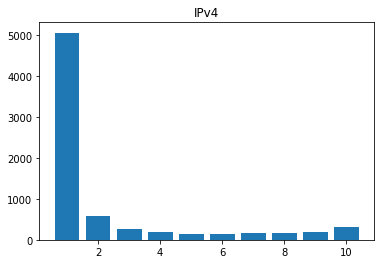

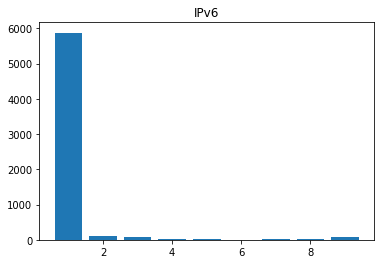

In [239]:
for key, df in buffersize_data_with_backend_ok:
    df_pub = df[df["resolver"] != "Probe Resolver"]
    df_pub = df_pub.groupby(["backend_resolver", "resolver", "as_name_backend"], as_index=False).size()
    df_pub = df_pub.groupby(["backend_resolver", "as_name_backend"], as_index=False).size() 
    group = df_pub.groupby("size").size().to_frame("resolver_count")
    fig, ax = plt.subplots()
    ax.bar(group.index, group["resolver_count"])
    ax.set_title(key)
    saver.save_figure(fig, f"number_resolvers_per_backend_count_{key}.pdf")
    top_ases = df_pub.value_counts("as_name_backend").index[:10].values
    df_pub = df_pub[df_pub["as_name_backend"].isin(top_ases)]
    ct = pd.crosstab(df_pub["as_name_backend"], df_pub["size"])
    ct = ct.reindex(top_ases)
    display(ct)


In [255]:
buffersize_data_with_backend_ok[0][1]

,msm_id,prb_id,sub_id,rt,dst_addr,frontend_udp_size,proto,use_probe_resolver,flags,header,...,resolver,resolver_protocol,failure,lat,lon,continent_code_backend,country_cody,asn,number_backend,as_name_backend
0,34856460,12894,1,591.62,1.1.1.1,1232,UDP,None,,"opcode: QUERY, status: NOERROR, id: 58276",...,Cloudflare,Public DoUDP,ok,-37.8136,144.96300,OC,AU,13335.0,13335.0,"CLOUDFLARENET - Cloudflare, Inc."
1,34856460,10001,1,31.269,1.1.1.1,1232,UDP,None,,"opcode: QUERY, status: NOERROR, id: 4566",...,Cloudflare,Public DoUDP,ok,52.3675,4.90410,EU,NL,13335.0,13335.0,"CLOUDFLARENET - Cloudflare, Inc."
2,34856460,10006,1,32.731,1.1.1.1,1232,UDP,None,,"opcode: QUERY, status: NOERROR, id: 18990",...,Cloudflare,Public DoUDP,ok,51.5073,-0.12770,EU,GB,13335.0,13335.0,"CLOUDFLARENET - Cloudflare, Inc."
3,34856460,10015,1,29.466,1.1.1.1,1232,UDP,None,,"opcode: QUERY, status: NOERROR, id: 50111",...,Cloudflare,Public DoUDP,ok,52.3675,4.90410,EU,NL,13335.0,13335.0,"CLOUDFLARENET - Cloudflare, Inc."
4,34856460,10022,1,29.146,1.1.1.1,1232,UDP,None,,"opcode: QUERY, status: NOERROR, id: 12819",...,Cloudflare,Public DoUDP,ok,52.3675,4.90410,EU,NL,13335.0,13335.0,"CLOUDFLARENET - Cloudflare, Inc."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3532458,34961524,25346,1,1188.277,1.1.1.1,1232,TCP,True,,"opcode: QUERY, status: NOERROR, id: 41322",...,Probe Resolver,Probe DoTCP,ok,32.0852,34.78170,AS,IL,13335.0,13335.0,"CLOUDFLARENET - Cloudflare, Inc."
3532463,34961524,29023,2,198.495,75.75.75.75,512,TCP,True,,"opcode: QUERY, status: NOERROR, id: 18664",...,Probe Resolver,Probe DoTCP,ok,37.3388,-121.89160,NaN,US,7922.0,7922.0,"COMCAST-7922 - Comcast Cable Communications, LLC"
3532469,34961524,34992,1,55.514,185.206.208.56,1232,TCP,True,cd,"opcode: QUERY, status: NOERROR, id: 24543",...,Probe Resolver,Probe DoTCP,ok,50.1013,8.57440,EU,DE,64475.0,64475.0,FREIFUNK-FRANKFURT
3532480,34961524,55381,1,492.395,165.169.76.108,4096,TCP,True,,"opcode: QUERY, status: NOERROR, id: 9164",...,Probe Resolver,Probe DoTCP,ok,-20.9562,55.30870,AF,RE,37002.0,37002.0,Reunicable


# Number of same probe, resolver and backend resolvers 

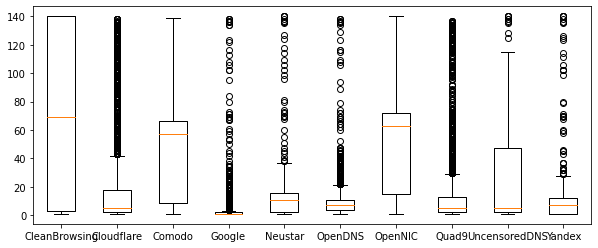

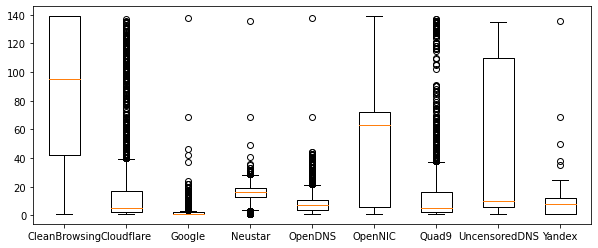

In [251]:
for key, df in buffersize_data_with_backend_ok:
    labels = []
    plots = []
    df_pub = df[df["resolver"] != "Probe Resolver"]
    groups = df_pub.groupby(["resolver"])

    for resolver, group in groups:
        group = group.groupby(["resolver", "backend_resolver", "prb_id"], as_index=False).size()
        sizes = group['size'].to_numpy()
        
        labels.append(resolver)
        plots.append(sizes)
    fig, ax_pub =  plt.subplots()
    fig.set_figwidth(10)
    ax_pub.set_xticklabels(labels)
    ax_pub.boxplot(plots)    

# Number of same probe, backend resolvers 

In [254]:
for key, df in buffersize_data_with_backend_ok:
    labels = []
    plots = []
    df_pub = df[df["resolver"] != "Probe Resolver"]
    df_pub = df_pub.groupby(["backend_resolver", "prb_id"], as_index=False).size()
    
    display(df_pub)

,backend_resolver,prb_id,size
0,103.107.197.18,20750,29
1,103.107.197.19,20750,17
2,103.107.197.19,24300,1
3,103.107.197.19,51534,92
4,103.107.197.20,20750,7
...,...,...,...
347456,95.179.224.81,55511,140
347457,95.179.224.81,55603,140
347458,95.179.224.81,55704,136
347459,95.179.224.81,55786,140


,backend_resolver,prb_id,size
0,103.107.199.244,14184,14
1,103.107.199.244,14843,22
2,103.107.199.244,19107,21
3,103.107.199.244,20750,29
4,103.107.199.244,23116,32
...,...,...,...
146286,95.179.224.81,54915,139
146287,95.179.224.81,55214,139
146288,95.179.224.81,55511,139
146289,95.179.224.81,55603,30


# Shared backend resolvers

In [265]:
import sqlite3

conn = sqlite3.connect("ripe_results_txt.db")
all_resolvers_and_backend_resolvers = pd.read_sql("""SELECT DISTINCT r.dst_addr, t.backend_resolver, m.use_probe_resolver
                                                      FROM measurements m JOIN 
                                                      results r ON r.msm_id = m.id  
                                                      JOIN txt_results t on r.msm_id = t.msm_id and 
                                                                            r.prb_id = t.prb_id and 
                                                                            r.sub_id = t.sub_id""", conn)

In [266]:
all_resolvers_and_backend_resolvers['resolver'] = all_resolvers_and_backend_resolvers.apply(create_resolver_column, axis=1)


In [268]:
all_resolvers_and_backend_resolvers = all_resolvers_and_backend_resolvers.merge(backend_resolvers, on="backend_resolver") 

In [269]:
all_resolvers_and_backend_resolvers

,dst_addr,backend_resolver,use_probe_resolver,resolver,lat,lon,continent_code,country_cody,asn
0,1.1.1.1,2400:cb00:47:1024::a29e:11c,None,Cloudflare,-37.8136,144.96300,OC,AU,13335
1,2606:4700:4700::1111,2400:cb00:47:1024::a29e:11c,None,Cloudflare,-37.8136,144.96300,OC,AU,13335
2,172.21.20.25,2400:cb00:47:1024::a29e:11c,True,Probe Resolver,-37.8136,144.96300,OC,AU,13335
3,192.168.1.53,2400:cb00:47:1024::a29e:11c,True,Probe Resolver,-37.8136,144.96300,OC,AU,13335
4,192.168.1.9,2400:cb00:47:1024::a29e:11c,True,Probe Resolver,-37.8136,144.96300,OC,AU,13335
...,...,...,...,...,...,...,...,...,...
61013,192.168.255.1,2001:1ae9:ff2:64a4:dd2:b88e:ba41:dfd6,True,Probe Resolver,50.0755,14.43780,EU,CZ,13036
61014,192.168.254.90,2001:8a0:2106:7::68,True,Probe Resolver,38.7303,-9.14699,EU,PT,3243
61015,192.168.20.254,12.121.117.89,True,Probe Resolver,32.9636,-96.74680,NaN,US,7018
61016,26.1.64.10,2a01:e0a:149:522f:1:0:7f3d:f6dd,True,Probe Resolver,47.2455,6.02090,EU,FR,12322


In [296]:
import plotly.express as px
from plotly.offline import plot, iplot, init_notebook_mode

init_notebook_mode(connected=True)
token = "pk.eyJ1IjoiZmF1bGluZ2VyIiwiYSI6ImNreHZ5Y2p4ODFhcWgyd281MG83NXk2OWsifQ.zKuf7xBkjTgCrsd-OD8s-Q"
px.set_mapbox_access_token(token)

def display_intersection(resolvers):
    result = all_resolvers_and_backend_resolvers[all_resolvers_and_backend_resolvers["resolver"] == resolvers[0]]["backend_resolver"].unique()
    for resolver in resolvers[1:]: 
        brs = all_resolvers_and_backend_resolvers[all_resolvers_and_backend_resolvers["resolver"] == resolver]["backend_resolver"].unique()
        result = list(set(result) & set(brs))
    df_result = all_resolvers_and_backend_resolvers[all_resolvers_and_backend_resolvers["backend_resolver"].isin(result)]
    print(f"Backend Resolvers commonly used by the given resolvers: {len(result)}")
    fig = px.scatter_mapbox(df_result,
                            lat=df_result.lat,
                            lon=df_result.lon,
                            hover_name="backend_resolver",
                            zoom=1)
    fig.show()        

### Number of backend resolvers per resolver

In [318]:
df = all_resolvers_and_backend_resolvers.groupby("resolver", as_index=False).size()

In [321]:
df.sort_values("size", ascending=False)

,resolver,size
7,Probe Resolver,36650
3,Google,9766
5,OpenDNS,2501
1,Cloudflare,2114
8,Quad9,2097
4,Neustar,1531
10,Yandex,1510
0,CleanBrowsing,1283
6,OpenNIC,1265
9,UncensoredDNS,1221


In [322]:
display_intersection(["Cloudflare", "Comodo"])

Backend Resolvers commonly used by the given resolvers: 737


In [323]:
test_df = buffersize_data[0][1]

In [71]:
conn = sqlite3.connect('ripe_results_txt.db', timeout=60)
results = pd.read_sql("SELECT * FROM results", conn)
results

,rt,size,sub_id,sub_max,msm_id,prb_id,ancount,qdcount,nscount,arcount,...,abuf,result_id,lts,dst_addr,dst_port,src_addr,af,proto,udp_size,return_code
0,591.62,358,1,1,34856460,12894,1,1,0,1,...,SIKBgAABAAEAAAABBTEyODk0CjE2NDI1ODM3NTcLbWVtYn...,18562,346,1.1.1.1,53,10.0.2.16,4,UDP,1232,NOERROR
1,31.269,344,1,1,34856460,10001,1,1,0,1,...,hQaBgAABAAEAAAABBTEwMDAxCjE2NDI1ODM3NjkLbWVtYn...,34054,7,1.1.1.1,53,192.168.178.30,4,UDP,1232,NOERROR
2,32.731,344,1,1,34856460,10006,1,1,0,1,...,ZzKBgAABAAEAAAABBTEwMDA2CjE2NDI1ODM3NjULbWVtYn...,26418,42,1.1.1.1,53,192.168.1.137,4,UDP,1232,NOERROR
3,29.466,366,1,1,34856460,10015,1,1,0,1,...,nJGBgAABAAEAAAABBTEwMDE1CjE2NDI1ODM3NjYLbWVtYn...,40081,43,1.1.1.1,53,192.168.178.39,4,UDP,1232,NOERROR
4,29.146,345,1,1,34856460,10022,1,1,0,1,...,9TyBgAABAAEAAAABBTEwMDIyCjE2NDI1ODM3NjQLbWVtYn...,62780,0,1.1.1.1,53,10.71.6.153,4,UDP,1232,NOERROR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4936242,None,None,2,2,34961524,53219,None,None,None,None,...,None,None,37,10.12.1.1,53,None,4,TCP,None,None
4936243,None,None,2,2,34961524,53888,None,None,None,None,...,None,None,1,192.168.77.6,53,None,4,TCP,None,None
4936244,492.395,344,1,3,34961524,55381,1,1,0,1,...,vWGBgAABAAEAAAABBTU1MzgxCjE2NDMxNTE4NDALbWVtYn...,48481,34,165.169.76.108,53,192.168.0.3,4,TCP,4096,NOERROR
4936245,None,None,2,2,34961524,55401,None,None,None,None,...,None,None,13,10.0.4.1,53,2a01:79d:7370:13ee:1:c9ff:fee1:9d33,4,TCP,None,None


In [72]:
import base64
from ripe.atlas.sagan.helpers import abuf
def get_question_name(row):
    data_qbuf = row["qbuf"]
    try:
        test = abuf.AbufParser.parse(base64.b64decode(data_qbuf))
        if test is not None and "QuestionSection" in test and len(test["QuestionSection"]) > 0: 
            question = test["QuestionSection"][0]
            if "Qname" in question:
                return question["Qname"]
            else:
                return None
        else: 
            return None
    except: 
        return None
        

In [73]:
r_head = results.head(100)

In [74]:
results["question_name"] = results.apply(get_question_name, axis=1)

In [75]:
results

,rt,size,sub_id,sub_max,msm_id,prb_id,ancount,qdcount,nscount,arcount,...,result_id,lts,dst_addr,dst_port,src_addr,af,proto,udp_size,return_code,question_name
0,591.62,358,1,1,34856460,12894,1,1,0,1,...,18562,346,1.1.1.1,53,10.0.2.16,4,UDP,1232,NOERROR,12894.1642583757.membrain-it.technology.
1,31.269,344,1,1,34856460,10001,1,1,0,1,...,34054,7,1.1.1.1,53,192.168.178.30,4,UDP,1232,NOERROR,10001.1642583769.membrain-it.technology.
2,32.731,344,1,1,34856460,10006,1,1,0,1,...,26418,42,1.1.1.1,53,192.168.1.137,4,UDP,1232,NOERROR,10006.1642583765.membrain-it.technology.
3,29.466,366,1,1,34856460,10015,1,1,0,1,...,40081,43,1.1.1.1,53,192.168.178.39,4,UDP,1232,NOERROR,10015.1642583766.membrain-it.technology.
4,29.146,345,1,1,34856460,10022,1,1,0,1,...,62780,0,1.1.1.1,53,10.71.6.153,4,UDP,1232,NOERROR,10022.1642583764.membrain-it.technology.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4936242,None,None,2,2,34961524,53219,None,None,None,None,...,None,37,10.12.1.1,53,None,4,TCP,None,None,None
4936243,None,None,2,2,34961524,53888,None,None,None,None,...,None,1,192.168.77.6,53,None,4,TCP,None,None,None
4936244,492.395,344,1,3,34961524,55381,1,1,0,1,...,48481,34,165.169.76.108,53,192.168.0.3,4,TCP,4096,NOERROR,55381.1643151840.membrain-it.technology.
4936245,None,None,2,2,34961524,55401,None,None,None,None,...,None,13,10.0.4.1,53,2a01:79d:7370:13ee:1:c9ff:fee1:9d33,4,TCP,None,None,None


In [77]:
dr = results.groupby(by=["question_name", "dst_addr", "prb_id"], as_index = False).size()

In [78]:
dr.sort_values("size", ascending=False)

,question_name,dst_addr,prb_id,size
1228377,19208.1643036488.membrain-it.technology.,90.145.32.32,19208,4
4102000,54169.1643014855.membrain-it.technology.,2001:8b0::2020,54169,3
727095,15171.1643014855.membrain-it.technology.,1.1.1.1,15171,3
2230846,28761.1643036487.membrain-it.technology.,8.8.8.8,28761,3
501505,13430.1642705262.membrain-it.technology.,8.8.8.8,13430,3
...,...,...,...,...
1539597,22296.1642914008.membrain-it.technology.,1.1.1.1,22296,1
1539598,22296.1642914009.membrain-it.technology.,8.8.8.8,22296,1
1539599,22296.1642914015.membrain-it.technology.,185.228.168.9,22296,1
1539600,22296.1642914016.membrain-it.technology.,208.67.222.222,22296,1


In [79]:
dr[dr["size"] > 1].sort_values("size", ascending=False)

,question_name,dst_addr,prb_id,size
1228377,19208.1643036488.membrain-it.technology.,90.145.32.32,19208,4
2230846,28761.1643036487.membrain-it.technology.,8.8.8.8,28761,3
3327712,50765.1643014855.membrain-it.technology.,1.1.1.1,50765,3
4102000,54169.1643014855.membrain-it.technology.,2001:8b0::2020,54169,3
727095,15171.1643014855.membrain-it.technology.,1.1.1.1,15171,3
...,...,...,...,...
1523804,22110.1642628708.membrain-it.technology.,1.1.1.1,22110,2
1523807,22110.1642628748.membrain-it.technology.,8.8.8.8,22110,2
1523808,22110.1642628759.membrain-it.technology.,185.228.168.9,22110,2
1523846,22110.1642643119.membrain-it.technology.,8.8.8.8,22110,2


In [80]:
dr[dr["size"] == 1]

,question_name,dst_addr,prb_id,size
0,0.1642942777.membrain-it.technology.,8.26.56.26,50996,1
2,10001.1642583770.membrain-it.technology.,8.8.8.8,10001,1
3,10001.1642583773.membrain-it.technology.,185.228.168.9,10001,1
4,10001.1642583780.membrain-it.technology.,8.8.8.8,10001,1
5,10001.1642583784.membrain-it.technology.,185.121.177.177,10001,1
...,...,...,...,...
4585897,55859.1643151683.membrain-it.technology.,64.6.64.6,55859,1
4585898,55859.1643151691.membrain-it.technology.,64.6.64.6,55859,1
4585899,55859.1643151692.membrain-it.technology.,77.88.8.8,55859,1
4585900,55859.1643151694.membrain-it.technology.,77.88.8.8,55859,1


In [367]:
c = results[results["question_name"] == "55711.1643101771.membrain-it.technology."]

In [368]:
c.to_csv("non_unique_domain_example.csv")

In [3]:
import sqlite3
conn = sqlite3.connect("ripe_results_txt.db")

In [6]:
test = pd.read_sql("SELECT * FROM txt_results WHERE proto = 'TCP'", conn)

In [7]:
test

,backend_resolver,proto,raw_data,msm_id,prb_id,sub_id,flags,header,query_count,ans_count,auth_count,addit_count,question,udp_size
0,2400:cb00:71:1024::a29e:5323,TCP,None,34872390,34992,1,,"opcode: QUERY, status: NOERROR, id: 34252",1,0,0,1,34992.1642698006.membrain-it.technology. IN TXT,1452
1,2400:cb00:71:1024::a29e:5321,TCP,None,34900653,35053,1,,"opcode: QUERY, status: NOERROR, id: 22913",1,0,0,1,35053.1642806007.membrain-it.technology. IN TXT,1452
2,2400:cb00:71:1024::a29e:5321,TCP,None,34900653,53314,1,,"opcode: QUERY, status: NOERROR, id: 15443",1,0,0,1,53314.1642806006.membrain-it.technology. IN TXT,1452
3,2001:1488:800:400::2:135,TCP,None,34912583,22478,2,cd,"opcode: QUERY, status: NOERROR, id: 13783",1,0,0,1,22478.1642878259.membrAIN-it.TEChNoLogY. IN TXT,1232
4,2400:cb00:71:1024::a29e:5323,TCP,None,34913741,31881,1,,"opcode: QUERY, status: NOERROR, id: 7523",1,0,0,1,31881.1642885211.membrain-it.technology. IN TXT,1452
5,2400:cb00:71:1024::a29e:553d,TCP,None,34945080,50768,1,,"opcode: QUERY, status: NOERROR, id: 36032",1,0,0,1,50768.1643058044.membrain-it.technology. IN TXT,1452
6,2400:cb00:83:1024::a29e:dd0a,TCP,None,34959047,17673,1,,"opcode: QUERY, status: NOERROR, id: 39719",1,0,0,1,17673.1643137205.membrain-it.technology. IN TXT,1452
7,2400:cb00:21:1024::8d65:6a2d,TCP,None,34960285,24858,1,,"opcode: QUERY, status: NOERROR, id: 33191",1,0,0,1,24858.1643144413.membrain-it.technology. IN TXT,1452
8,2400:cb00:114:1024::ac44:3157,TCP,None,34961465,54460,1,,"opcode: QUERY, status: NOERROR, id: 23683",1,0,0,1,54460.1643151605.membrain-it.technology. IN TXT,1452


In [13]:
test = pd.read_sql("SELECT * FROM txt_results t LEFT JOIN pseudosection_results p ON t.msm_id = p.msm_id and t.prb_id = p.prb_id and t.sub_id = p.sub_id ", conn)

In [14]:
test

,backend_resolver,proto,raw_data,msm_id,prb_id,sub_id,flags,header,query_count,ans_count,auth_count,addit_count,question,udp_size,id,msm_id,prb_id,sub_id,name,content
0,2400:cb00:47:1024::a29e:11c,UDP,None,34856460,12894,1,,"opcode: QUERY, status: NOERROR, id: 58276",1.0,0.0,0.0,1.0,12894.1642583757.membrain-it.technology. IN TXT,1452.0,205875.0,34856460.0,12894.0,1.0,EDNS,version 0; flags: do; udp: 1452
1,141.101.64.253,UDP,None,34856460,10001,1,,"opcode: QUERY, status: NOERROR, id: 4566",1.0,0.0,0.0,1.0,10001.1642583769.membrain-it.technology. IN TXT,1452.0,205876.0,34856460.0,10001.0,1.0,EDNS,version 0; flags: do; udp: 1452
2,172.70.84.169,UDP,None,34856460,10006,1,,"opcode: QUERY, status: NOERROR, id: 18990",1.0,0.0,0.0,1.0,10006.1642583765.membrain-it.technology. IN TXT,1452.0,205877.0,34856460.0,10006.0,1.0,EDNS,version 0; flags: do; udp: 1452
3,141.101.75.35,UDP,None,34856460,10015,1,,"opcode: QUERY, status: NOERROR, id: 50111",1.0,0.0,0.0,1.0,10015.1642583766.membrain-it.technology. IN TXT,1452.0,205878.0,34856460.0,10015.0,1.0,EDNS,version 0; flags: do; udp: 1452
4,141.101.64.253,UDP,None,34856460,10022,1,,"opcode: QUERY, status: NOERROR, id: 12819",1.0,0.0,0.0,1.0,10022.1642583764.membrain-it.technology. IN TXT,1452.0,205879.0,34856460.0,10022.0,1.0,EDNS,version 0; flags: do; udp: 1452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4613966,172.69.129.101,UDP,None,34961524,25346,1,,"opcode: QUERY, status: NOERROR, id: 41322",1.0,0.0,0.0,1.0,25346.1643151846.membrain-it.technology. IN TXT,1452.0,4817337.0,34961524.0,25346.0,1.0,EDNS,version 0; flags: do; udp: 1452
4613967,76.96.15.101,UDP,None,34961524,29023,2,,"opcode: QUERY, status: NOERROR, id: 18664",1.0,0.0,0.0,1.0,29023.1643151847.membrain-it.technology. IN TXT,1232.0,4817338.0,34961524.0,29023.0,2.0,EDNS,version 0; flags: do; udp: 1232
4613968,185.206.210.100,UDP,None,34961524,34992,1,cd,"opcode: QUERY, status: NOERROR, id: 24543",1.0,0.0,0.0,1.0,34992.1643151844.mEMbRaIn-it.tEchnOLOGy. IN TXT,1232.0,4817339.0,34961524.0,34992.0,1.0,EDNS,version 0; flags: do; udp: 1232
4613969,165.169.76.171,UDP,None,34961524,55381,1,,"opcode: QUERY, status: NOERROR, id: 9164",1.0,0.0,0.0,1.0,55381.1643151840.membrain-it.technology. IN TXT,1680.0,4817340.0,34961524.0,55381.0,1.0,EDNS,version 0; flags: do; udp: 1680


In [21]:
test["name"].unique()

array(['EDNS', 'COOKIE', 'SUBNET', None], dtype=object)

In [22]:
df_test = test[test["name"] == "SUBNET"]

In [26]:
df_test.groupby("backend_resolver", as_index = False).size().sort_values("size", ascending = False)

,backend_resolver,size
4107,54.37.84.182,250
3613,2a00:1450:400a:1001::103,199
3611,2a00:1450:400a:1001::101,186
3620,2a00:1450:400a:1002::105,183
571,172.253.12.5,182
...,...,...
948,172.253.217.11,1
947,172.253.217.10,1
2330,2607:f8b0:4001:c2f::103,1
935,172.253.216.12,1


In [48]:
test

,backend_resolver,proto,raw_data,msm_id,prb_id,sub_id,flags,header,query_count,ans_count,auth_count,addit_count,question,udp_size,id,msm_id,prb_id,sub_id,name,content
0,2400:cb00:47:1024::a29e:11c,UDP,None,34856460,12894,1,,"opcode: QUERY, status: NOERROR, id: 58276",1.0,0.0,0.0,1.0,12894.1642583757.membrain-it.technology. IN TXT,1452.0,205875.0,34856460.0,12894.0,1.0,EDNS,version 0; flags: do; udp: 1452
1,141.101.64.253,UDP,None,34856460,10001,1,,"opcode: QUERY, status: NOERROR, id: 4566",1.0,0.0,0.0,1.0,10001.1642583769.membrain-it.technology. IN TXT,1452.0,205876.0,34856460.0,10001.0,1.0,EDNS,version 0; flags: do; udp: 1452
2,172.70.84.169,UDP,None,34856460,10006,1,,"opcode: QUERY, status: NOERROR, id: 18990",1.0,0.0,0.0,1.0,10006.1642583765.membrain-it.technology. IN TXT,1452.0,205877.0,34856460.0,10006.0,1.0,EDNS,version 0; flags: do; udp: 1452
3,141.101.75.35,UDP,None,34856460,10015,1,,"opcode: QUERY, status: NOERROR, id: 50111",1.0,0.0,0.0,1.0,10015.1642583766.membrain-it.technology. IN TXT,1452.0,205878.0,34856460.0,10015.0,1.0,EDNS,version 0; flags: do; udp: 1452
4,141.101.64.253,UDP,None,34856460,10022,1,,"opcode: QUERY, status: NOERROR, id: 12819",1.0,0.0,0.0,1.0,10022.1642583764.membrain-it.technology. IN TXT,1452.0,205879.0,34856460.0,10022.0,1.0,EDNS,version 0; flags: do; udp: 1452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4613966,172.69.129.101,UDP,None,34961524,25346,1,,"opcode: QUERY, status: NOERROR, id: 41322",1.0,0.0,0.0,1.0,25346.1643151846.membrain-it.technology. IN TXT,1452.0,4817337.0,34961524.0,25346.0,1.0,EDNS,version 0; flags: do; udp: 1452
4613967,76.96.15.101,UDP,None,34961524,29023,2,,"opcode: QUERY, status: NOERROR, id: 18664",1.0,0.0,0.0,1.0,29023.1643151847.membrain-it.technology. IN TXT,1232.0,4817338.0,34961524.0,29023.0,2.0,EDNS,version 0; flags: do; udp: 1232
4613968,185.206.210.100,UDP,None,34961524,34992,1,cd,"opcode: QUERY, status: NOERROR, id: 24543",1.0,0.0,0.0,1.0,34992.1643151844.mEMbRaIn-it.tEchnOLOGy. IN TXT,1232.0,4817339.0,34961524.0,34992.0,1.0,EDNS,version 0; flags: do; udp: 1232
4613969,165.169.76.171,UDP,None,34961524,55381,1,,"opcode: QUERY, status: NOERROR, id: 9164",1.0,0.0,0.0,1.0,55381.1643151840.membrain-it.technology. IN TXT,1680.0,4817340.0,34961524.0,55381.0,1.0,EDNS,version 0; flags: do; udp: 1680
